# Imports

In [ ]:
!git clone https://github.com/sudhanshu22gupta/cryptocurrency-forecasting.git

Cloning into 'cryptocurrency-forecasting'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 105 (delta 44), reused 80 (delta 24), pack-reused 0
Receiving objects: 100% (105/105), 10.62 MiB | 6.57 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [ ]:
%cd /content/cryptocurrency-forecasting

/content/cryptocurrency-forecasting


In [1]:
%reload_ext autoreload
%autoreload 2

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from glob import glob
from tqdm import tqdm
import pickle

from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr, ttest_rel
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 100

In [3]:
from data_transformation import CleanData
from features_library import FeatureTransformations
from regression import (
                        BaseReg,
                        RandomForestReg, 
                        HistGradientBoostingReg, 
                        SGDReg, 
                        ElasticNetReg, 
                        TheilSenReg,
                        RANSACReg
                        )
from trading_strategies import TradingStrategy
from performance_metrics import PerformanceMetrics

In [4]:
np.random.seed(2)

# Load Data

In [5]:
DIR_CRYPTO_DATA = "./data/1_Crypto_data/"
DIR_FINANCIAL_DATA = "./data/1_Financial_component_data/"

In [6]:
dict_assets = {}
ASSETS_SELECTED = [
    'BTC-USD',
    'ETH-USD',
    'XRP-USD',
    'LTC-USD',
]

for file_crypto in glob(f"{DIR_CRYPTO_DATA}*.csv"):

    # Read CSV
    asset_name = os.path.basename(file_crypto).split(".")[0]
    if not asset_name in ASSETS_SELECTED:
        continue
    df_asset = pd.read_csv(file_crypto)

    # Pre-Process Data
    preproc = CleanData(df_asset)
    preproc.make_datetime_index(date_col='Date')
    preproc.resample(freq='1D')
    preproc.strip_column_name()

    # assign to dict
    dict_assets[asset_name] = preproc.df


In [7]:
dict_fd = {}
for file_fd in glob(f"{DIR_FINANCIAL_DATA}*.csv"):

    # Read CSV
    fd_name = os.path.basename(file_fd).split(".")[0]
    df_fd = pd.read_csv(file_fd)

    if fd_name.startswith("F-F"):
        df_fd = df_fd.loc[df_fd['Date']>19700101]
        df_fd["Date"] = df_fd["Date"].astype(str)
        df_fd["Date"] = df_fd["Date"].apply(lambda x: f"{x[:4]}-{x[4:6]}-{x[6:8]}")

    # Pre-Process Data
    preproc = CleanData(df_fd)
    preproc.make_datetime_index(date_col='Date')
    preproc.resample(freq='1D')
    preproc.strip_column_name()
    preproc.ffill()

    # Keep??
    # if ('Adj Close' not in df_fd.columns) and ('Close' in df_fd.columns):
    #     df_fd['Adj Close'] = df_fd['Close'].copy()

    # assign to dict
    dict_fd[fd_name] = preproc.df

In [8]:
df_risk_free = pd.read_excel(os.path.join(DIR_FINANCIAL_DATA, "RiskFree.xls"))
df_risk_free.index = df_risk_free['TcmDate']
df_risk_free.index.name = None
df_risk_free = df_risk_free[['Tcm1mo', 'Tcm3mo', 'Tcm1yr', 'Tcm5yr', 'Tcm10yr']]
df_risk_free = df_risk_free.resample('1D').first().ffill()
df_risk_free

Tcm1mo  Tcm3mo  Tcm1yr  Tcm5yr  Tcm10yr
1997-01-02  0.0519  0.0519  0.0563  0.0630   0.0654
1997-01-03  0.0517  0.0517  0.0560  0.0628   0.0652
1997-01-04  0.0517  0.0517  0.0560  0.0628   0.0652
1997-01-05  0.0517  0.0517  0.0560  0.0628   0.0652
1997-01-06  0.0517  0.0517  0.0561  0.0630   0.0654
...            ...     ...     ...     ...      ...
2023-03-16  0.0422  0.0474  0.0449  0.0372   0.0356
2023-03-17  0.0431  0.0452  0.0426  0.0344   0.0339
2023-03-18  0.0431  0.0452  0.0426  0.0344   0.0339
2023-03-19  0.0431  0.0452  0.0426  0.0344   0.0339
2023-03-20  0.0434  0.0481  0.0434  0.0356   0.0347

[9574 rows x 5 columns]

# Feature Engineering

## Make Feature Transformations

For Assets, apply all feature transformations

In [9]:
for asset in dict_assets:
    feature_transformer = FeatureTransformations(dict_assets[asset])
    feature_transformer.transform_assets()
    dict_assets[asset] = feature_transformer.df_asset

For S&P500, apply selected feature transformations

In [10]:
dict_fd['S_P 500 index']['Volume'] = np.nan
# dict_fd['S_P 500 index'] = dict_fd['S_P 500 index'].ffill()
feature_transformer = FeatureTransformations(dict_fd['S_P 500 index'])
feature_transformer.transform_snp500()
dict_fd['S_P 500 index'] = feature_transformer.df_asset
dict_fd['S_P 500 index'].drop(columns=['Volume'], inplace=True)

## Add Financial Data to assets

In [11]:
for asset_name, df_asset in dict_assets.items():
    
    ASSET_START_PERIOD = df_asset.index.min()
    ASSET_END_PERIOD = df_asset.index.max()

    for financial_dataset, df_fd in dict_fd.items():

        df_fd = df_fd[ASSET_START_PERIOD:ASSET_END_PERIOD]
        
        rename_fd_cols = {column: f"{financial_dataset}_{column}".replace(" ", "_") for column in df_fd.columns}
        df_fd.rename(columns=rename_fd_cols, inplace=True)
        df_asset = pd.concat([df_asset, df_fd], axis=1)
    
    # add risk-free info
    df_asset = pd.concat([df_asset, df_risk_free[ASSET_START_PERIOD:ASSET_END_PERIOD]], axis=1)
    
    dict_assets[asset_name] = df_asset

## Normalize Features

In [66]:
# for asset_name, df_asset in dict_assets.items():
#     scaler = StandardScaler()
#     df_asset[df_asset.columns] = scaler.fit_transform(df_asset)
#     dict_assets[asset_name] = df_asset

# EDA Plots

## Describe Price Movements

Plot of close price trends with high-low indicators

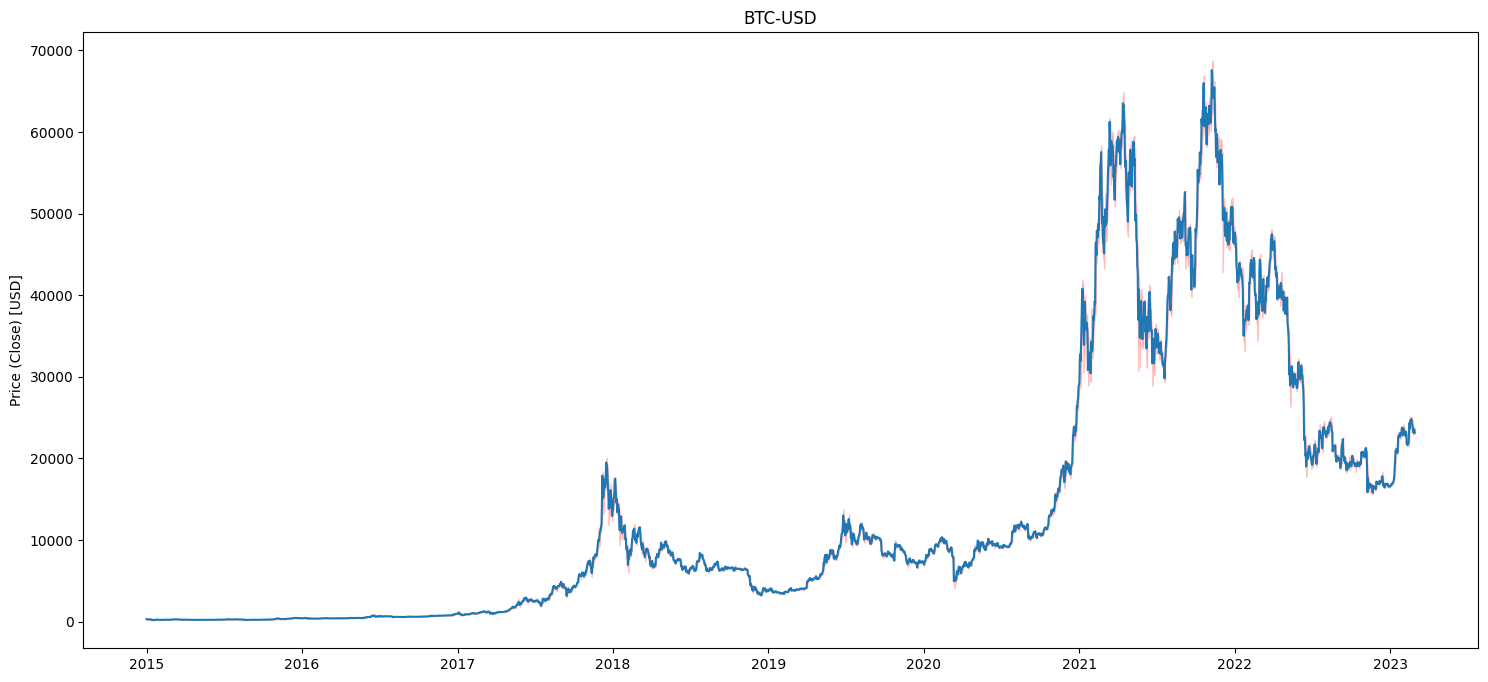

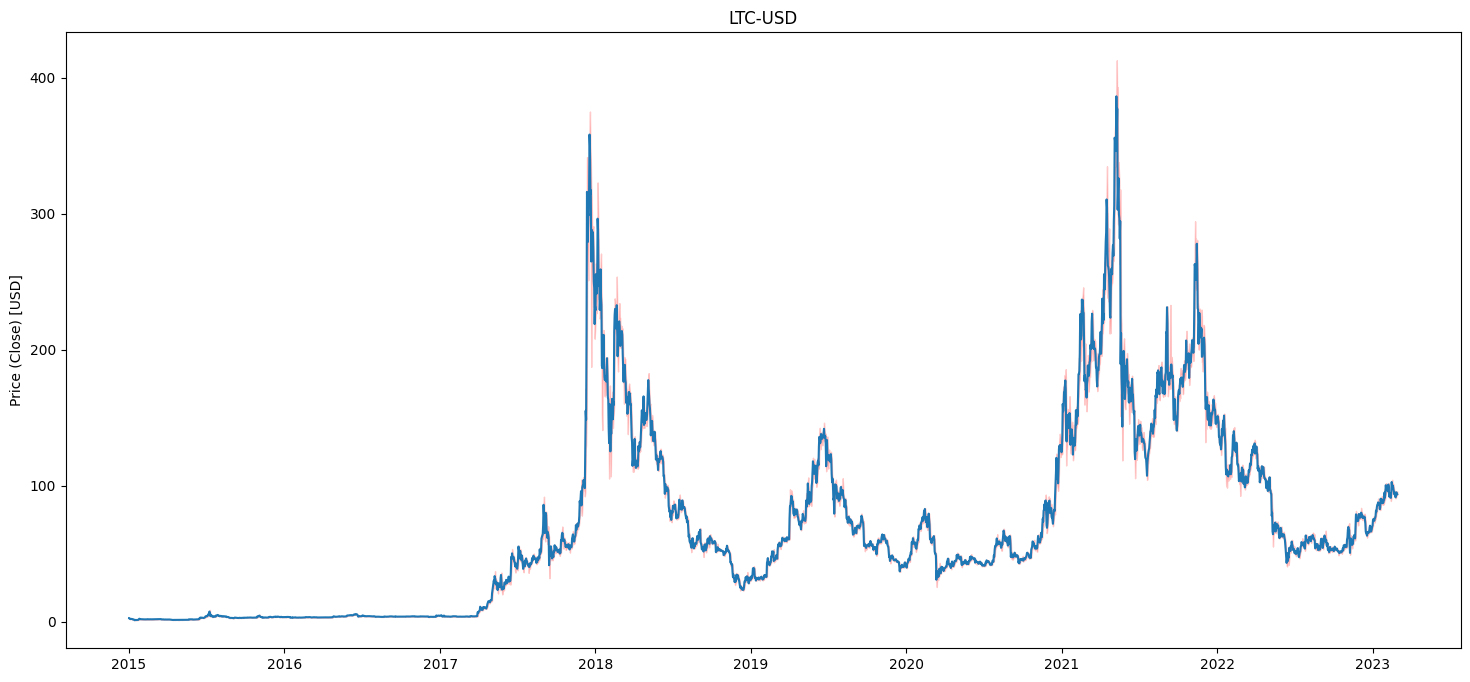

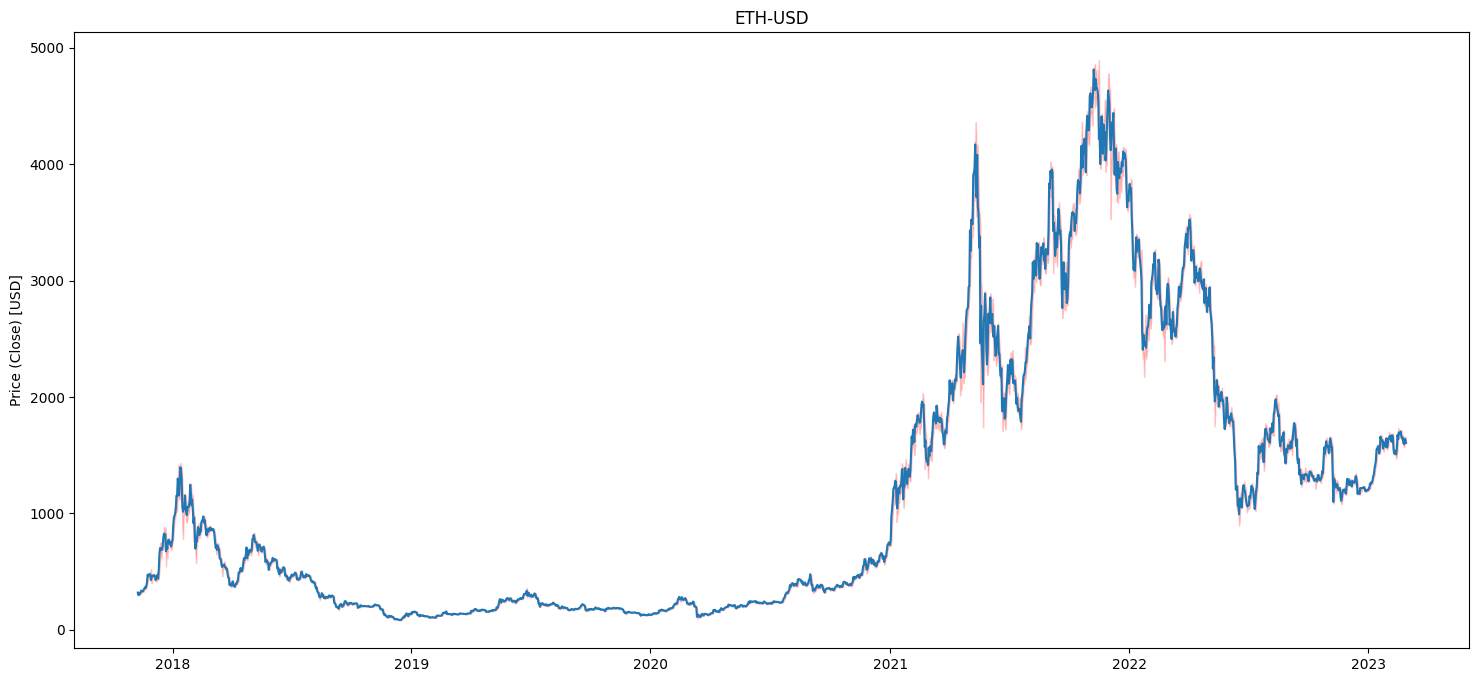

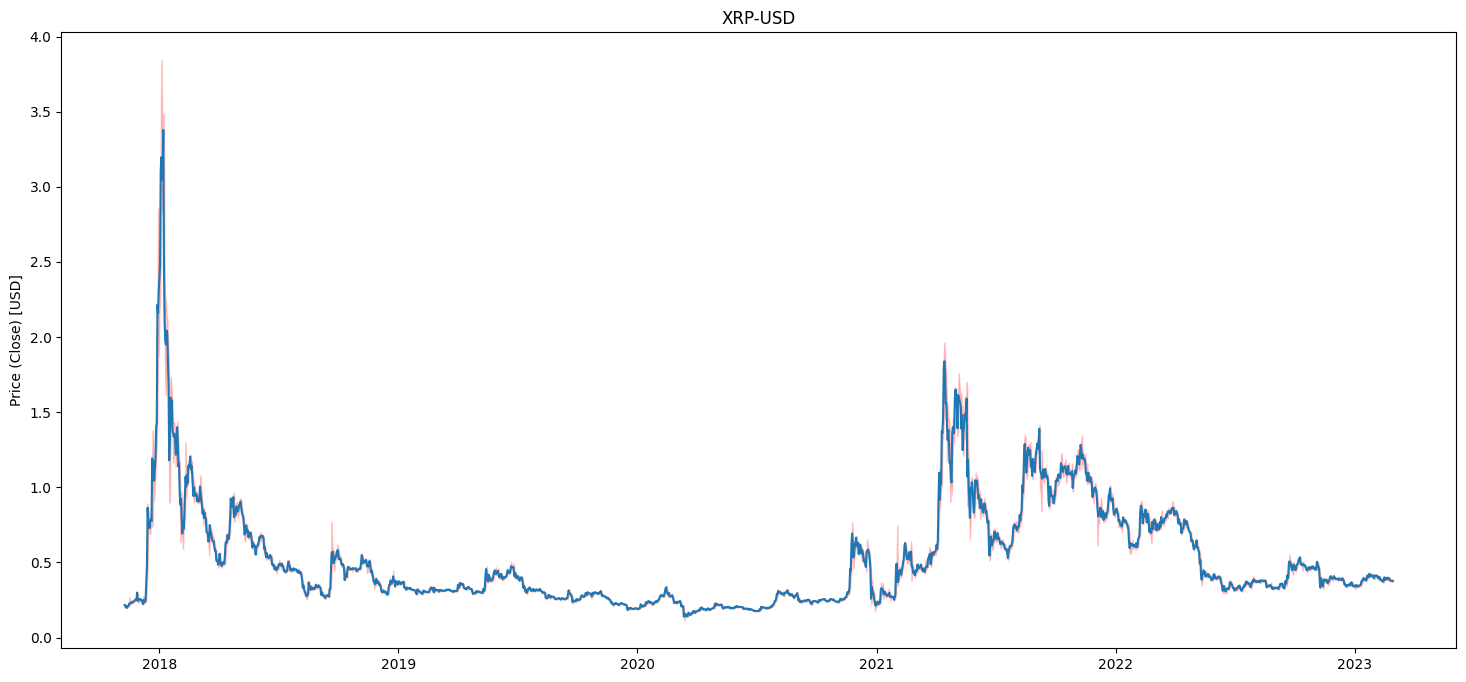

In [ ]:
nrows = len(df_asset)
ncols = 1


for idx, (asset_name, df_asset) in enumerate(dict_assets.items()):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(18, 8))
    df_plot = df_asset#['2022-01-01': '2022-06-30']
    ax.plot(df_plot['Close'])

    ax.fill_between(
        df_plot.index, 
        df_plot['High'], 
        df_plot['Low'], 
        alpha=0.2,
        color='red',
        interpolate=False,
        )
    ax.set_title(asset_name)
    ax.set_ylabel("Price (Close) [USD]")
    
    plt.show()

Plot of close price trends of all assets

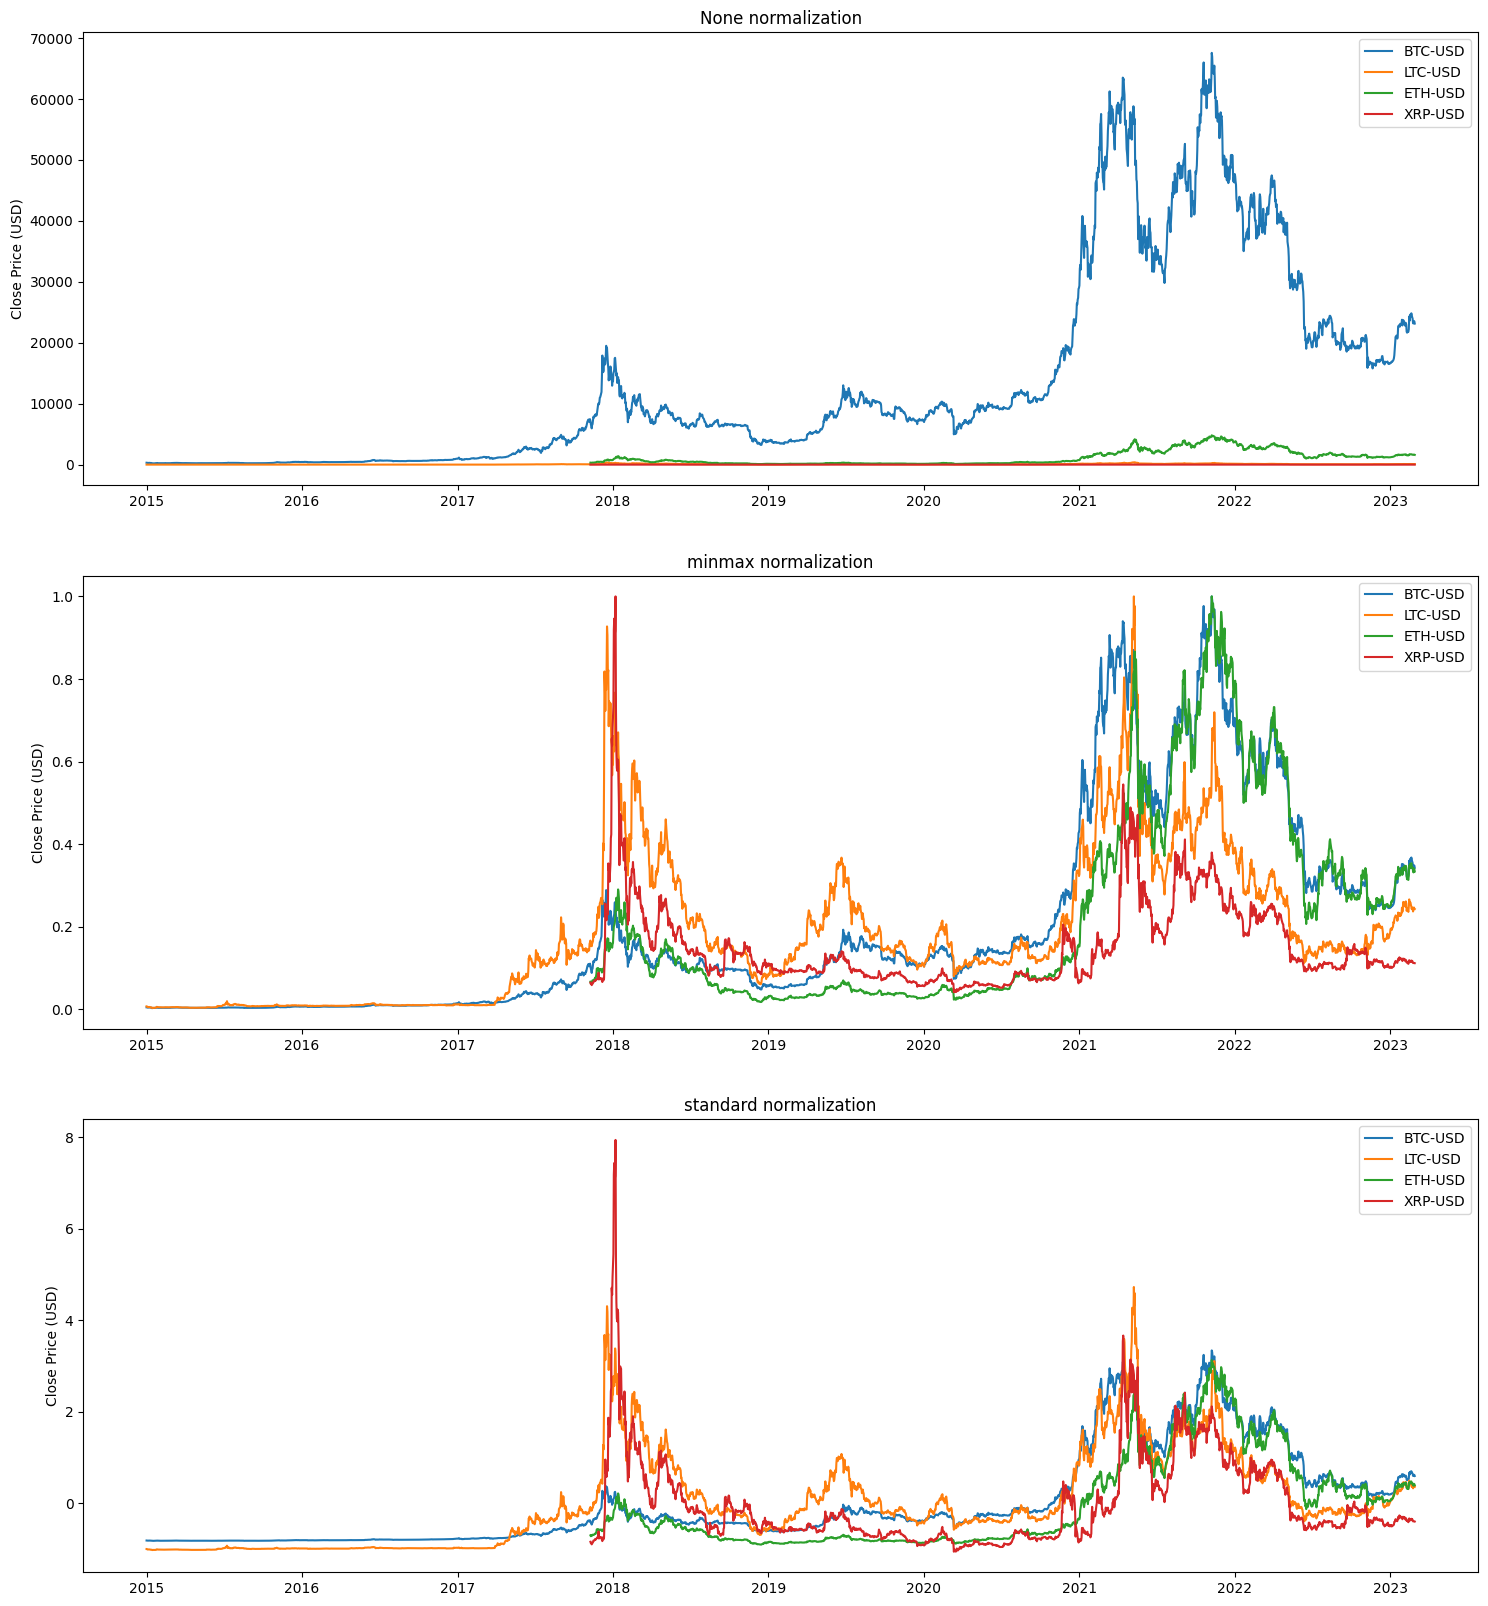

In [ ]:
NORM = [None, 'minmax', 'standard']

nrows, ncols = len(NORM), 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 20))

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(dict_assets)))
ax.set_prop_cycle('color', colors)

for idx, (asset_name, df_asset) in enumerate(dict_assets.items()):
    # if asset_name == 'BTC-USD':
    #     continue
    df_plot = df_asset # ['2021-01-01':]
    for idx, norm_method in enumerate(NORM):
        ax = axs[idx]
        if norm_method==None:
            ax.plot(df_plot['Close'], label=asset_name)
        
        elif norm_method=='minmax':
            ax.plot(df_plot['Close']/df_plot['Close'].max(), label=asset_name)
        elif norm_method=='standard':
            standard_scaler = StandardScaler()
            ax.plot(
                pd.Series(
                    standard_scaler.fit_transform(df_plot['Close'].values.reshape(-1, 1)).reshape(1,-1)[0],
                    index=df_plot['Close'].index
                    ), 
                    label=asset_name)
        ax.set_title(f"{str(norm_method)} normalization")
        ax.set_ylabel(f"Close Price (USD)")
        ax.legend()

plt.show()

## Describe Returns

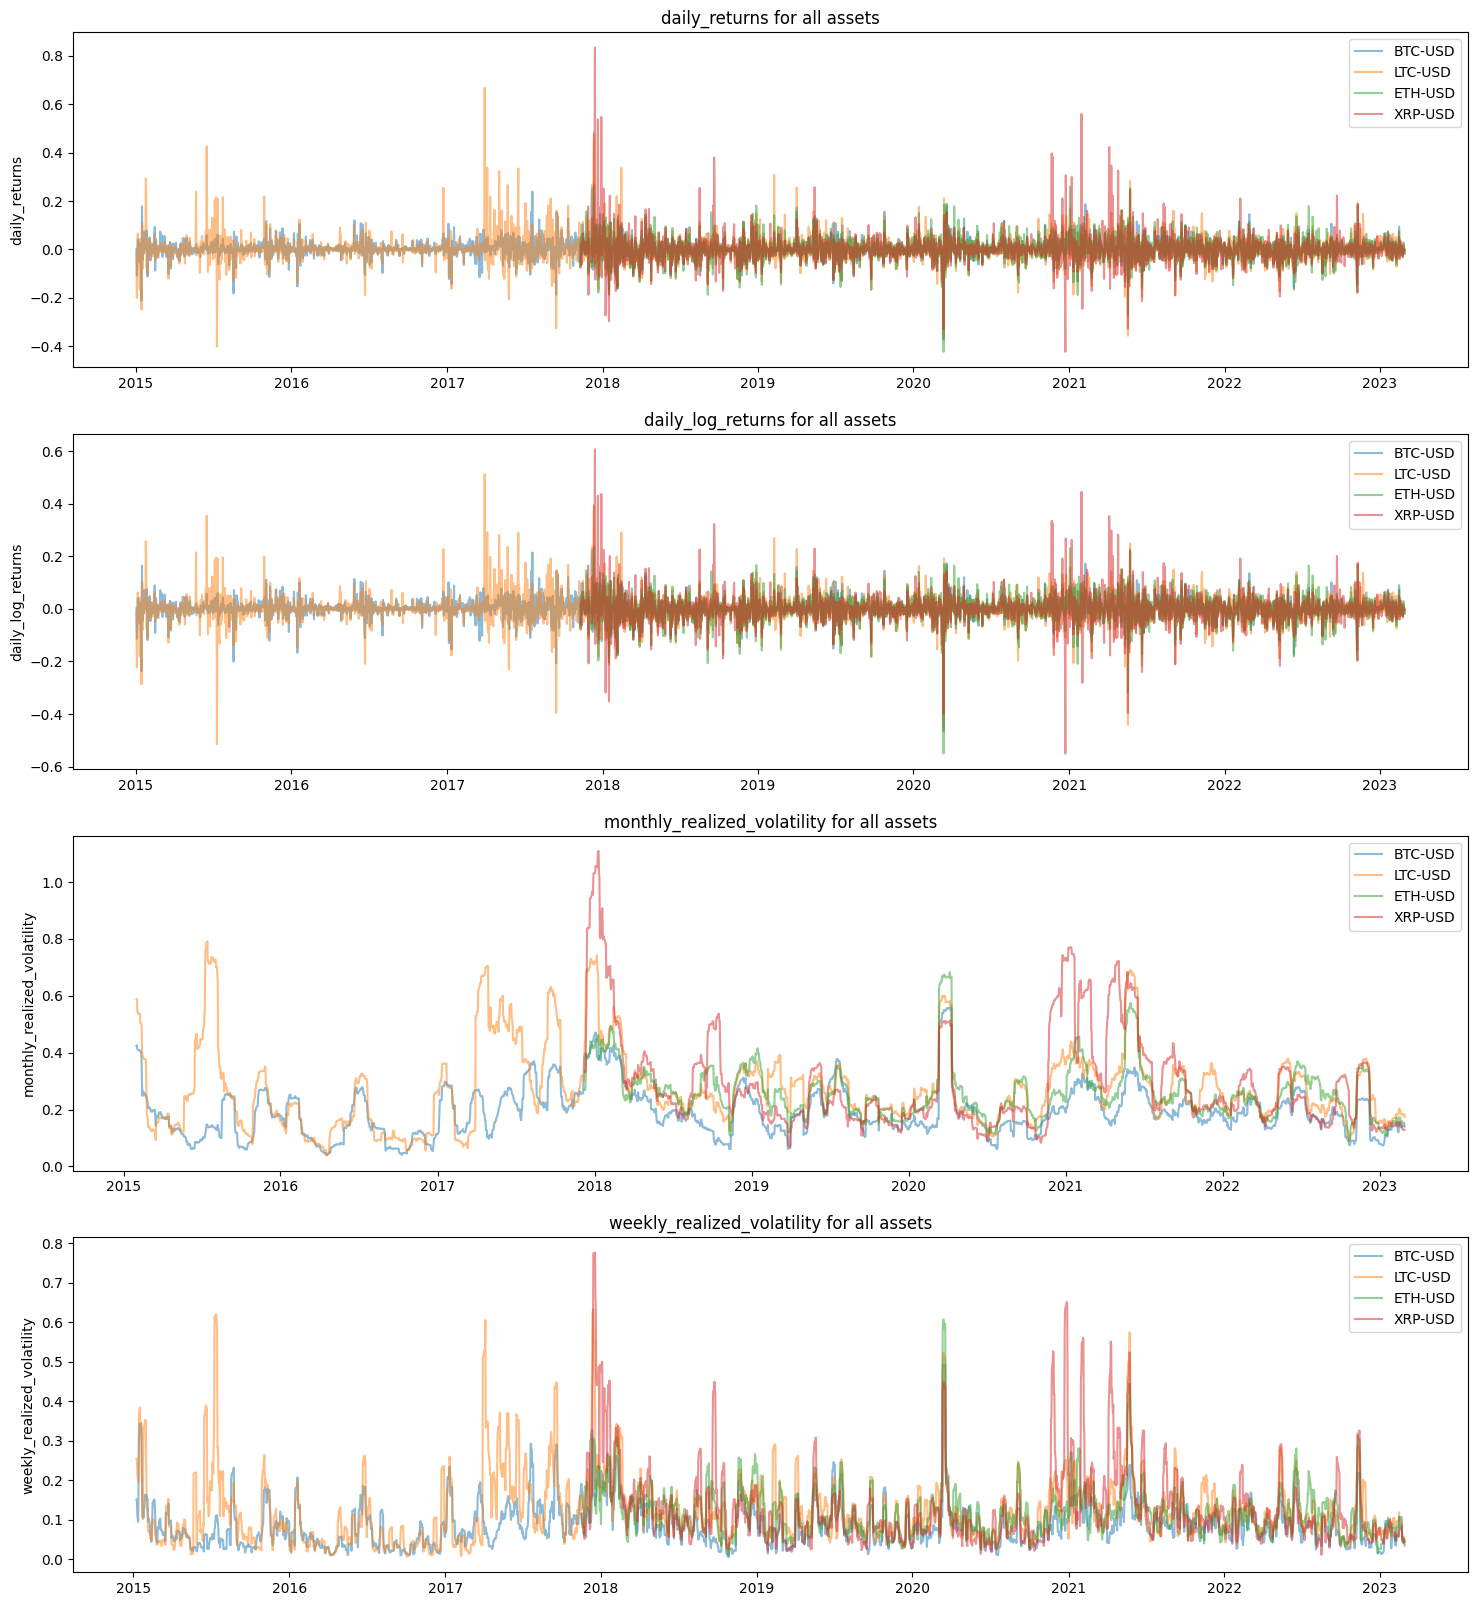

In [ ]:
RETURN_VARS = ['daily_returns', 'daily_log_returns', 'monthly_realized_volatility', 'weekly_realized_volatility']

nrows, ncols = len(RETURN_VARS), 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 20))

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(dict_assets)))
ax.set_prop_cycle('color', colors)

for idx, return_var in enumerate(RETURN_VARS):
    ax = axs[idx]
    for asset_name, df_asset in dict_assets.items():
        # if asset_name == 'BTC-USD':
        #     continue
        df_plot = df_asset#['2021-01-01':]
        ax.plot(df_plot[return_var], label=asset_name, alpha=0.5)
        
    ax.set_title(f"{str(return_var)} for all assets")
    ax.set_ylabel(str(return_var))
    ax.legend(loc='upper right')
    
plt.show()

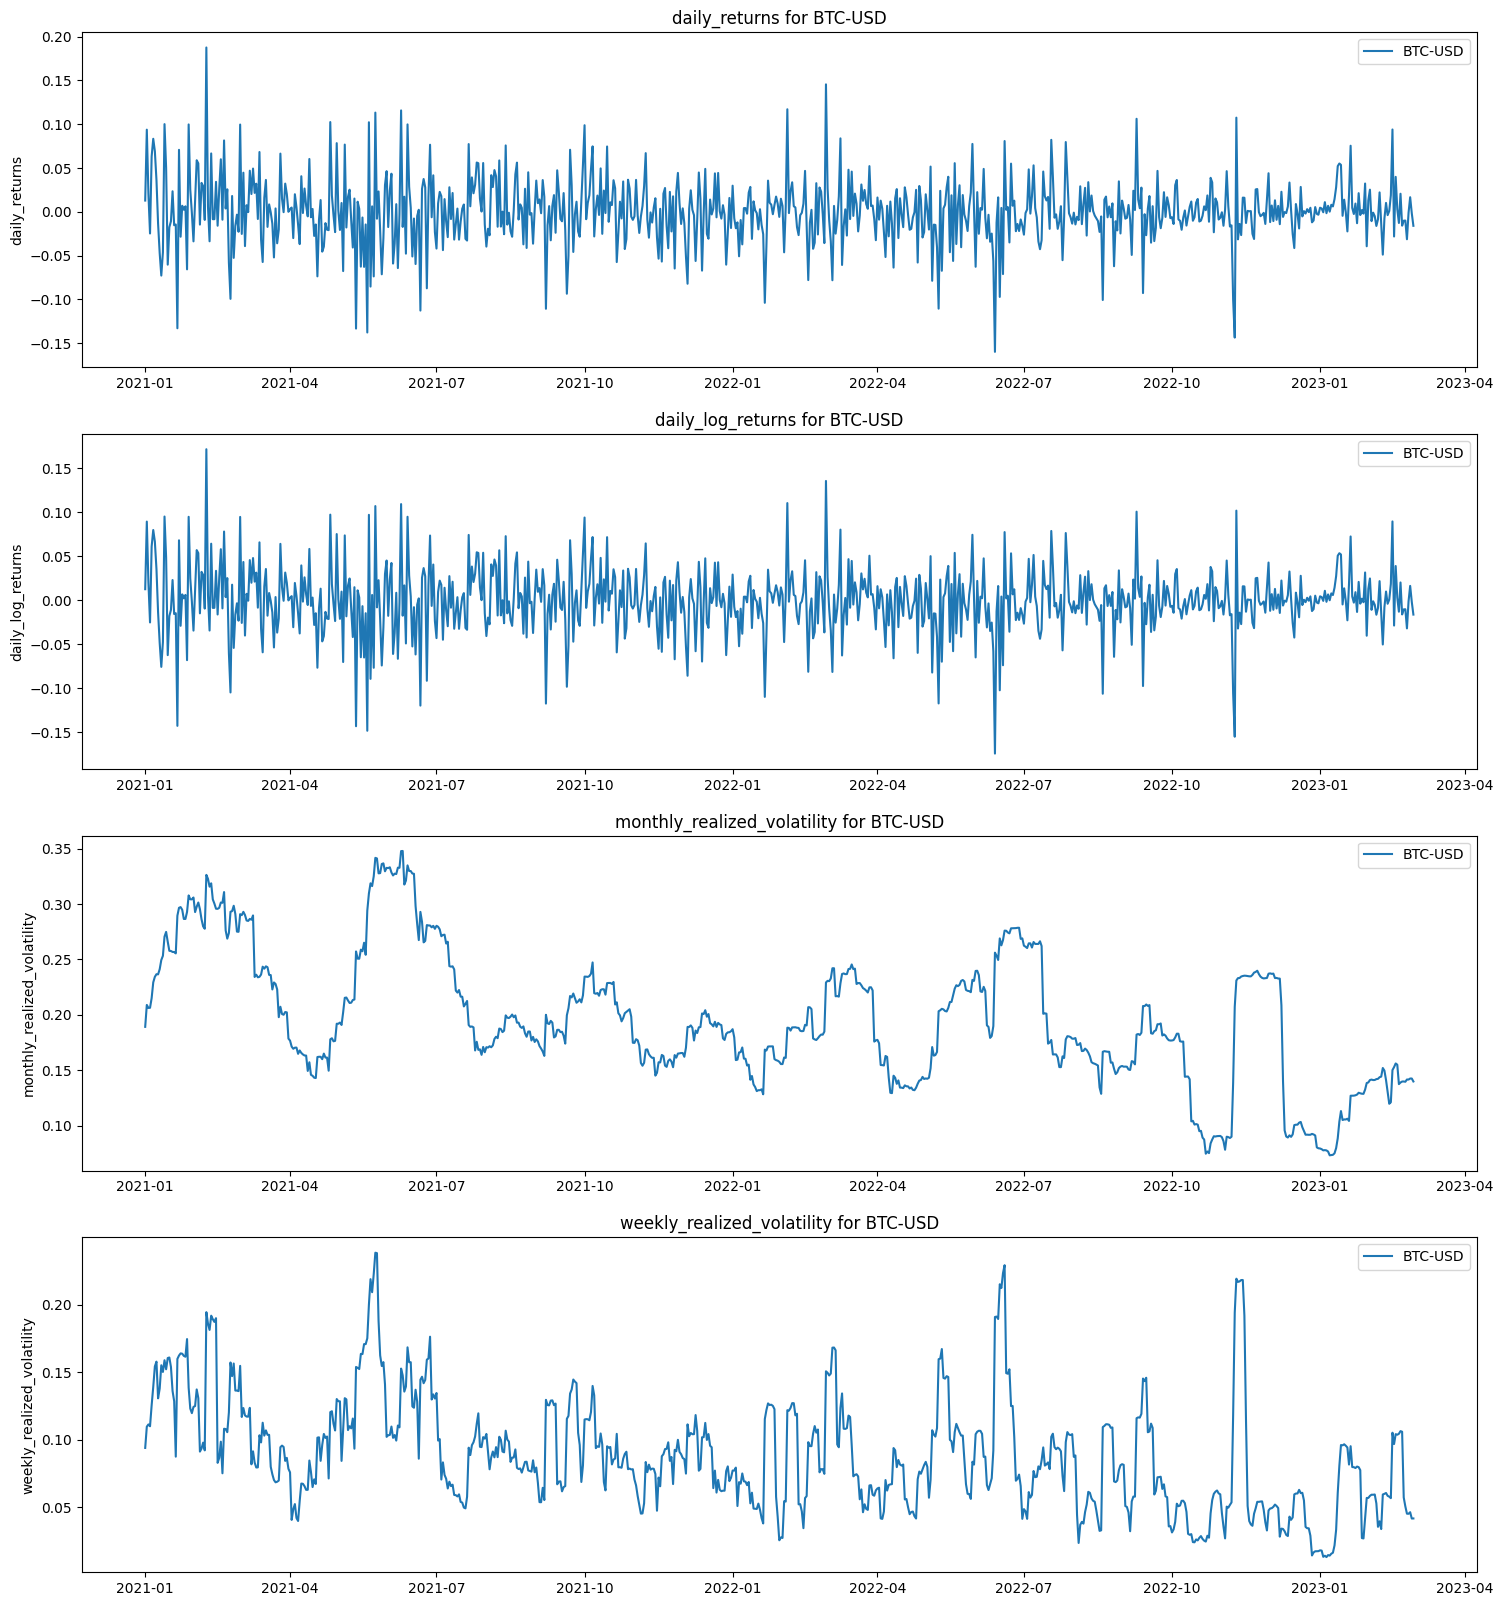

In [ ]:
RETURN_VARS = ['daily_returns', 'daily_log_returns', 'monthly_realized_volatility', 'weekly_realized_volatility']
ASSET_NAME = 'BTC-USD'

nrows, ncols = len(RETURN_VARS), 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 20))

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(dict_assets)))
ax.set_prop_cycle('color', colors)

for idx, return_var in enumerate(RETURN_VARS):
    ax = axs[idx]
    df_asset = dict_assets[ASSET_NAME]
    df_plot = df_asset['2021-01-01':]
    ax.plot(df_plot[return_var], label=ASSET_NAME)

    ax.set_title(f"{str(return_var)} for {ASSET_NAME}")
    ax.set_ylabel(str(return_var))
    ax.legend()

plt.show()

## Correlation

Correlations between explanatory variables of each asset

In [ ]:
df_asset = dict_assets['BTC-USD']

<Axes: >

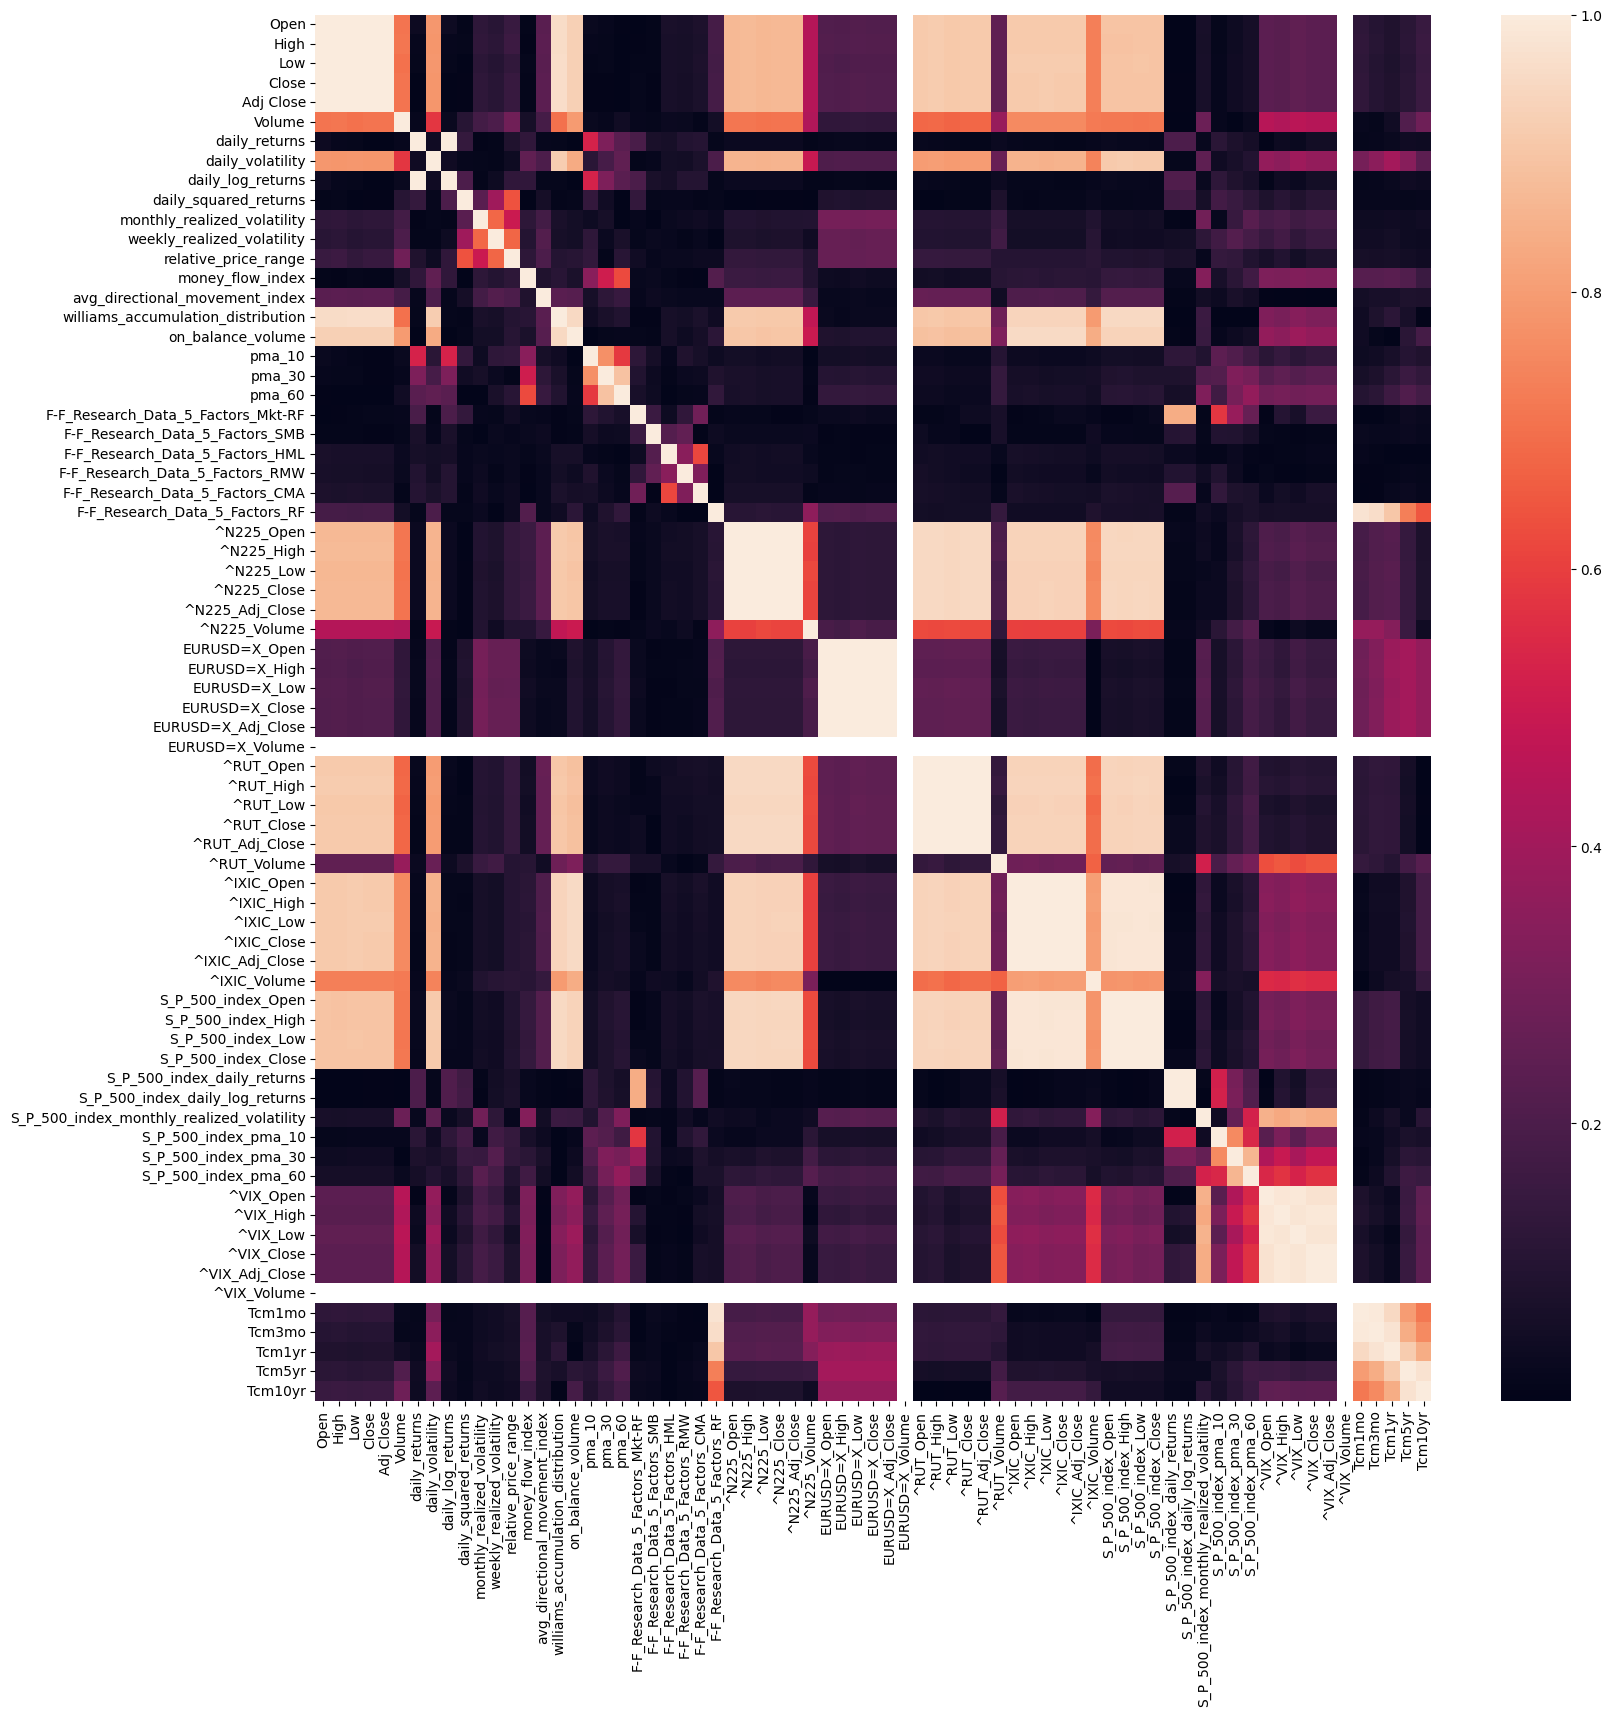

In [ ]:
#full time-frame from inception in 2015 onwards
df_asset_corr = abs(df_asset['2015-01-01':].corr())

plt.figure(figsize=(18, 18))
sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
    ax=plt.gca()
)

<Axes: >

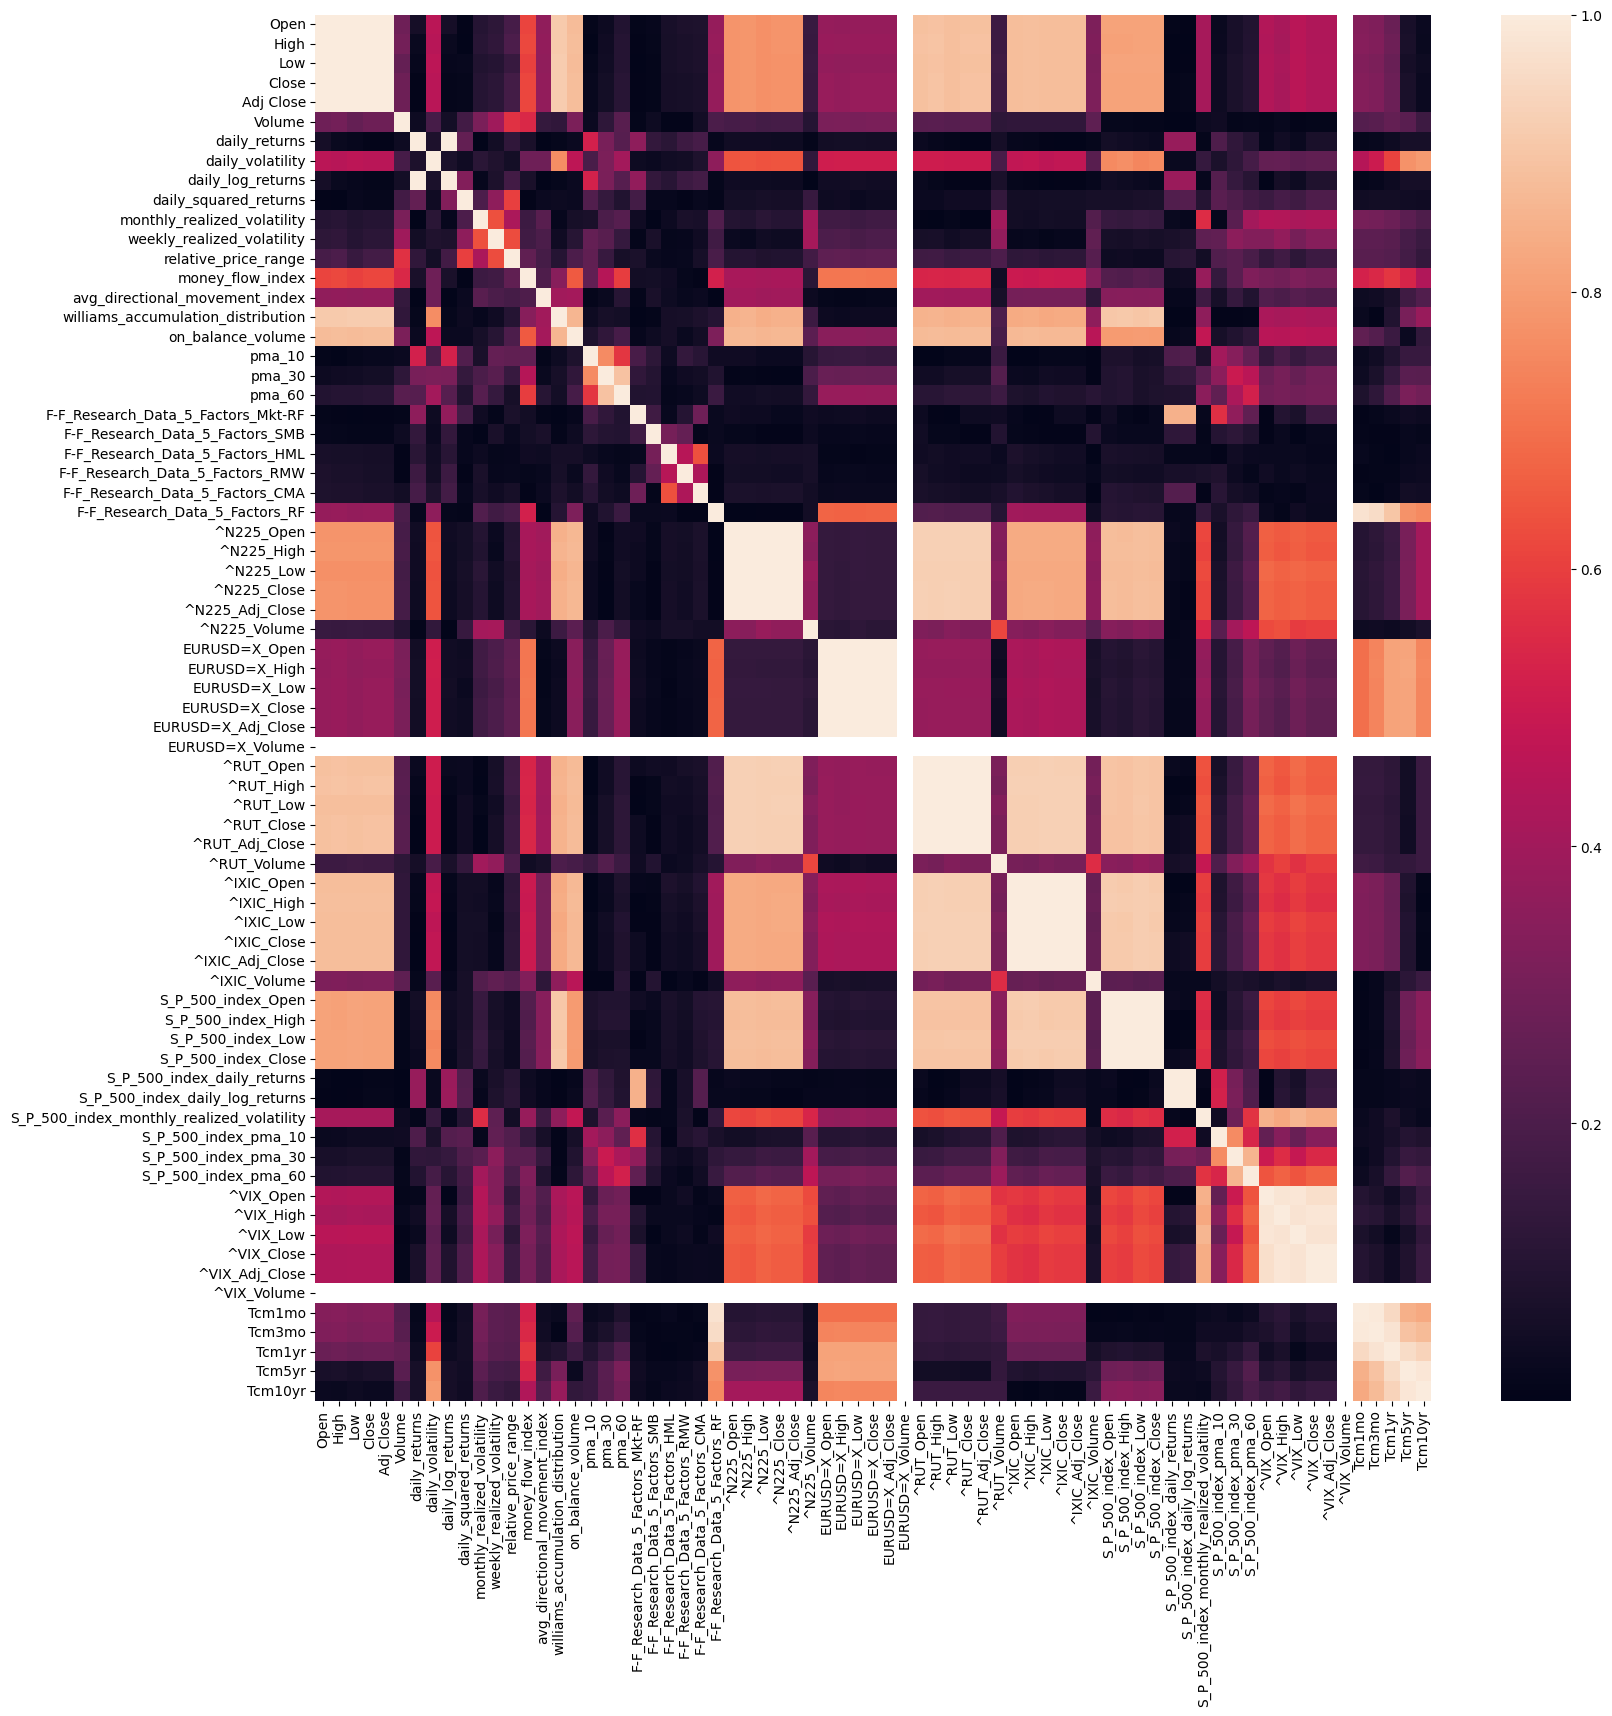

In [ ]:
#analysis time-frame 2020 onwards
df_asset_corr = abs(df_asset['2020-01-01':].corr())

plt.figure(figsize=(18, 18))
sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
    ax=plt.gca()
)

<Axes: >

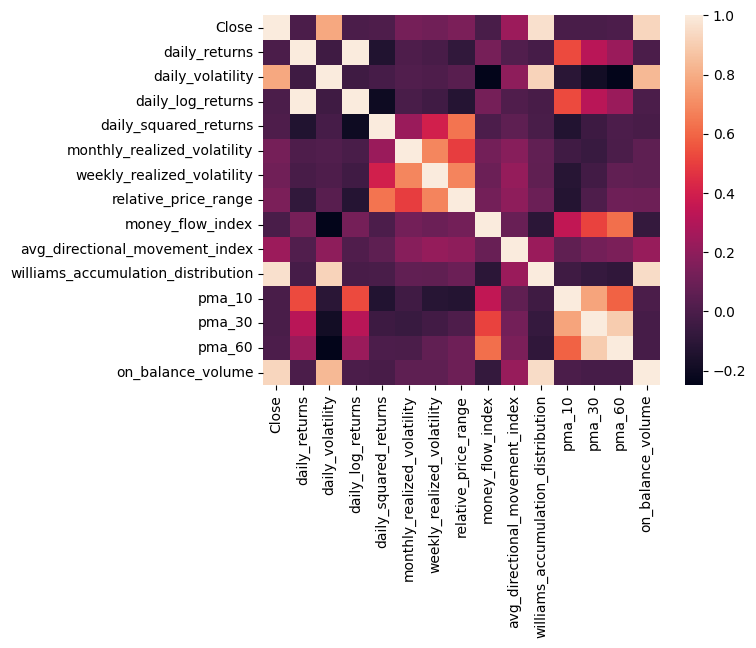

In [ ]:
CALC_FEATS = [
    'daily_returns','daily_volatility', 'daily_log_returns', 'daily_squared_returns',
    'monthly_realized_volatility', 'weekly_realized_volatility', 'relative_price_range', 
    'money_flow_index', 'avg_directional_movement_index', 'williams_accumulation_distribution',
    'pma_10', 'pma_30', 'pma_60', 'on_balance_volume'
    ]

df_asset_corr = df_asset[['Close'] + CALC_FEATS].corr()

sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
)

<Axes: >

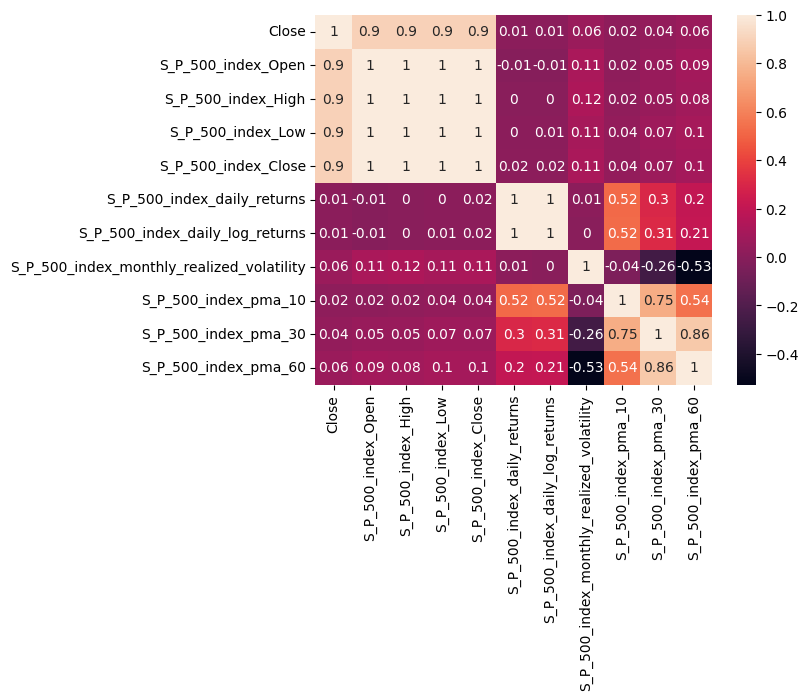

In [ ]:
CALC_FEATS = [col for col in df_asset.columns if 'S_P_500' in col]

df_asset_corr = df_asset[['Close'] + CALC_FEATS].corr()

sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
    annot=np.round(df_asset_corr.values, 2),
)

<Axes: >

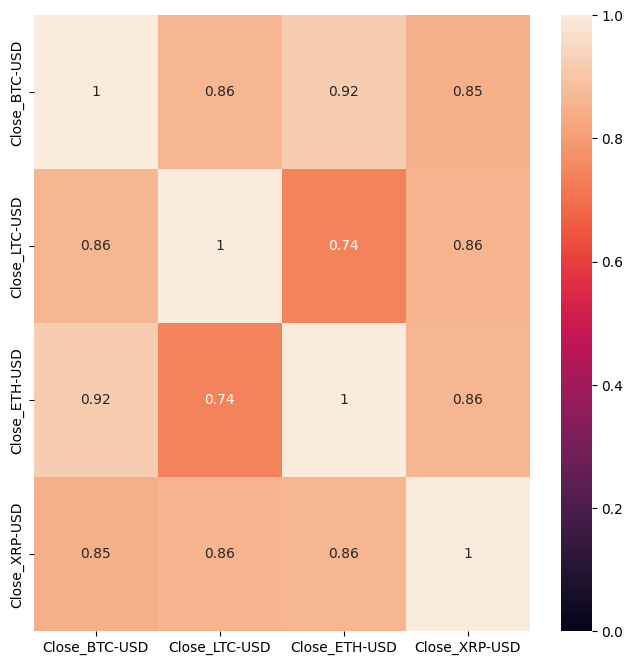

In [ ]:
#starting from 2019 because the assets became available since then
df_close_all_assets = pd.concat([df_asset['Close'].rename(f"Close_{asset_name}") for asset_name, df_asset in dict_assets.items()], axis=1)


TIME_PERIOD_START = '2019-01-01'
TIME_PERIOD_END = None #'2023-01-01'

if TIME_PERIOD_START:
    df_close_all_assets = df_close_all_assets[TIME_PERIOD_START:]
if TIME_PERIOD_END:
    df_close_all_assets = df_close_all_assets[:TIME_PERIOD_END]

df_all_asset_corr = df_close_all_assets.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(
    df_all_asset_corr,
    xticklabels=df_all_asset_corr.columns,
    yticklabels=df_all_asset_corr.columns,
    annot=df_all_asset_corr.values,
    ax=plt.gca(),
    vmin=0,
)

<Axes: >

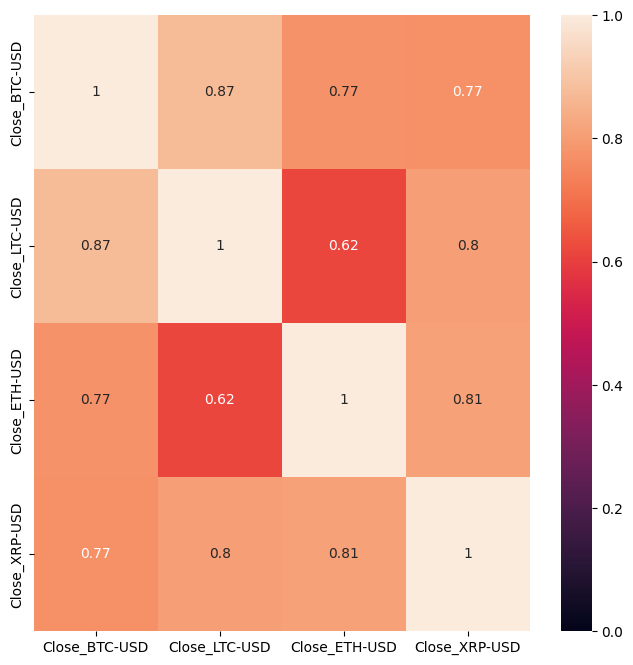

In [ ]:
#training period starts from 2021, so another view of correlations
df_close_all_assets = pd.concat([df_asset['Close'].rename(f"Close_{asset_name}") for asset_name, df_asset in dict_assets.items()], axis=1)


TIME_PERIOD_START = '2021-01-01'
TIME_PERIOD_END = None #'2023-01-01'

if TIME_PERIOD_START:
    df_close_all_assets = df_close_all_assets[TIME_PERIOD_START:]
if TIME_PERIOD_END:
    df_close_all_assets = df_close_all_assets[:TIME_PERIOD_END]

df_all_asset_corr = df_close_all_assets.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(
    df_all_asset_corr,
    xticklabels=df_all_asset_corr.columns,
    yticklabels=df_all_asset_corr.columns,
    annot=df_all_asset_corr.values,
    ax=plt.gca(),
    vmin=0,
)

In [ ]:
df_close_btc_eth = pd.concat(
    [
        dict_assets['BTC-USD']['Close'].rename("Close_BTC-USD"), 
        dict_assets['ETH-USD']['Close'].rename("Close_ETH-USD"), 
    ], 
    axis=1,
)
df_close_btc_eth = df_close_btc_eth.dropna()
df_close_btc_eth = df_close_btc_eth.resample('1D').first()

corr_btc_eth_mean = pearsonr(df_close_btc_eth['Close_BTC-USD'], df_close_btc_eth['Close_ETH-USD']).statistic
corr_btc_eth_60d_roll = df_close_btc_eth['Close_BTC-USD'].rolling('60D', min_periods=60).corr(df_close_btc_eth['Close_ETH-USD'])

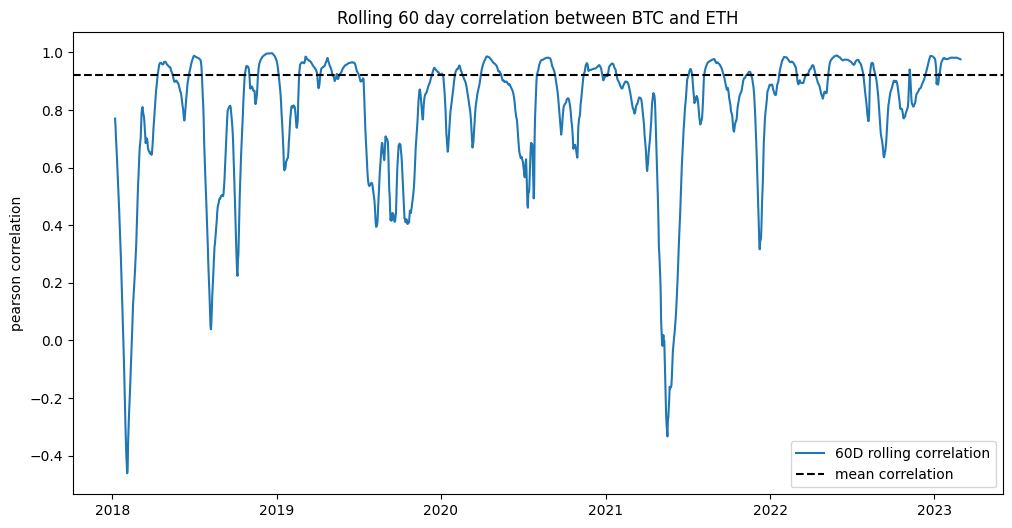

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(corr_btc_eth_60d_roll, label='60D rolling correlation')
plt.axhline(corr_btc_eth_mean, color='black', ls='--', label='mean correlation')

plt.title("Rolling 60 day correlation between BTC and ETH")
plt.ylabel("pearson correlation")
plt.legend()

## Descriptive Stats
N, min value, 1st quantile, median, mean, standard deviation, 3rd quantile, max value, skewness, kurtosis

In [ ]:
pd.options.display.max_columns = 100

In [ ]:
df_close_all_assets = pd.concat([df_asset['Close'].rename(f"Close_{asset_name}") for asset_name, df_asset in dict_assets.items()], axis=1)

df_descriptive_stats = pd.concat([
    df_close_all_assets.describe(), 
    pd.DataFrame(df_close_all_assets.kurtosis(), columns=['kurtosis']).T,
    pd.DataFrame(df_close_all_assets.skew(), columns=['skewness']).T,
])
df_descriptive_stats

Close_BTC-USD  Close_LTC-USD  Close_ETH-USD  Close_XRP-USD
count       2981.000000    2981.000000    1938.000000    1938.000000
mean       13481.524369      69.656052    1142.440624       0.520195
std        16181.118403      66.984527    1172.103874       0.359689
min          178.102997       1.157010      84.308296       0.139635
25%          920.382019       4.219910     213.643108       0.288724
50%         7556.237793      54.807610     559.634278       0.388867
75%        19044.107422     100.378006    1718.111817       0.656891
max        67566.828125     386.450775    4812.087402       3.377810
kurtosis       1.130637       1.653547       0.361284       9.853790
skewness       1.472561       1.291831       1.179694       2.419911

# Regression

In [12]:
df_asset = dict_assets['BTC-USD']
TARGET = 'daily_log_returns'

In [13]:
FEATURES_LIST_HAND_PICKED = [
    'Close', 'daily_volatility', 'Volume',
    'monthly_realized_volatility', 'weekly_realized_volatility',
    'relative_price_range', 'money_flow_index',
    'avg_directional_movement_index', 'williams_accumulation_distribution',
    'on_balance_volume', #'pma_10', 'pma_30', 'pma_60',
    
    'S_P_500_index_Close', 'S_P_500_index_pma_10', 'S_P_500_index_pma_30',
     'S_P_500_index_pma_60',
    'S_P_500_index_daily_log_returns',

    '^N225_Close', '^IXIC_Close', 'EURUSD=X_Close', '^VIX_Close', '^RUT_Close',

    'Tcm1mo', 'Tcm1yr', 'Tcm5yr', 'Tcm10yr',

    'F-F_Research_Data_5_Factors_Mkt-RF', 
    #'F-F_Research_Data_5_Factors_SMB', 'F-F_Research_Data_5_Factors_HML', 'F-F_Research_Data_5_Factors_RMW',
    #'F-F_Research_Data_5_Factors_CMA', 'F-F_Research_Data_5_Factors_RF',
]

len(FEATURES_LIST_HAND_PICKED)

25

<Axes: >

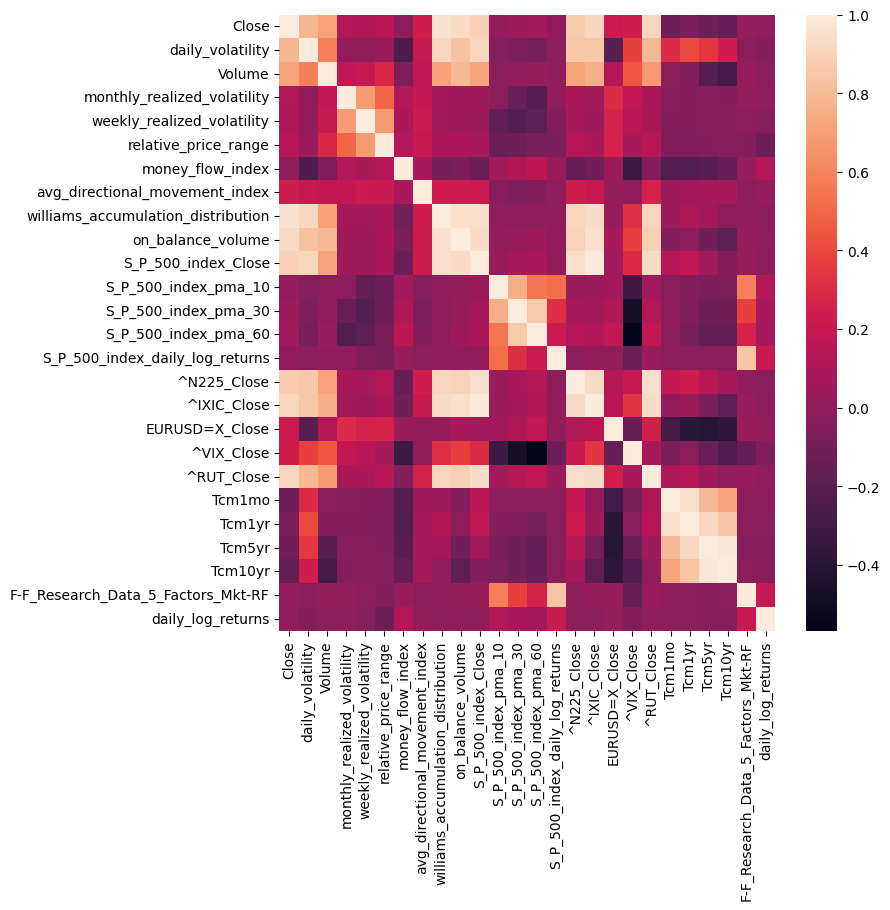

In [14]:
corr = df_asset[FEATURES_LIST_HAND_PICKED+[TARGET]].corr()

plt.figure(figsize=(8, 8))
sns.heatmap(
    corr,
    xticklabels=corr.columns,
    yticklabels=corr.columns,
    # annot=corr.values,
    ax=plt.gca(),
    # vmin=0,
)

In [15]:
TRAIN_DATE_RANGE = ("2018-01-01", "2021-12-31")
TEST_DATE_RANGE = ("2022-01-01", "2022-06-30")
OOS_DATE_RANGE = ("2022-07-01", "2022-12-31")

In [16]:
def train_test_split(df_asset, TRAIN_DATE_RANGE, TEST_DATE_RANGE, OOS_DATE_RANGE, FEATURES_LIST, TARGET, norm=False):
    
    df_asset_tts = df_asset.copy()
    df_asset_tts[TARGET] = df_asset_tts[TARGET].shift(periods=-1)
    df_asset_tts = df_asset_tts[FEATURES_LIST + [TARGET]]
    print(f"{df_asset_tts.shape=}")
    if norm:
        scaler = StandardScaler()
        df_asset_tts[FEATURES_LIST] = scaler.fit_transform(df_asset_tts[FEATURES_LIST])
        with open("./assets/scaler.pkl", "wb") as f:
            pickle.dump(scaler, f)
    
    df_asset_train = df_asset_tts[TRAIN_DATE_RANGE[0]: TRAIN_DATE_RANGE[1]]
    df_asset_test = df_asset_tts[TEST_DATE_RANGE[0]: TEST_DATE_RANGE[1]]
    df_asset_oos = df_asset_tts[OOS_DATE_RANGE[0]: OOS_DATE_RANGE[1]]
    
    X_train, Y_train = df_asset_train[FEATURES_LIST], df_asset_train[TARGET]
    X_test, Y_test = df_asset_test[FEATURES_LIST], df_asset_test[TARGET]
    X_oos, Y_oos = df_asset_oos[FEATURES_LIST], df_asset_oos[TARGET]

    print(f"""
    {X_train.shape=}, {Y_train.shape=}, 
    {X_test.shape=}, {Y_test.shape=},
    {X_oos.shape=}, {Y_oos.shape=},
    """)

    return X_train, Y_train, X_test, Y_test, X_oos, Y_oos

In [17]:
X_train, Y_train, X_test, Y_test, X_oos, Y_oos = train_test_split(
    df_asset=df_asset, 
    TRAIN_DATE_RANGE=TRAIN_DATE_RANGE, 
    TEST_DATE_RANGE=TEST_DATE_RANGE, 
    OOS_DATE_RANGE=OOS_DATE_RANGE,
    FEATURES_LIST=FEATURES_LIST_HAND_PICKED, 
    TARGET=TARGET, 
    norm=False,
    )

df_asset_tts.shape=(2981, 26)

    X_train.shape=(1461, 25), Y_train.shape=(1461,), 
    X_test.shape=(181, 25), Y_test.shape=(181,),
    X_oos.shape=(184, 25), Y_oos.shape=(184,),
    


In [18]:
X_train.describe()

Close  daily_volatility        Volume  \
count   1461.000000       1461.000000  1.461000e+03   
mean   18375.242011       5780.942251  2.574825e+10   
std    17760.299775       3617.367291  2.116603e+10   
min     3236.761719       2909.620607  2.923670e+09   
25%     7116.804199       3826.496687  8.041160e+09   
50%     9475.277344       3991.343328  2.225681e+10   
75%    29001.720703       4840.610266  3.621693e+10   
max    67566.828125      15892.528466  3.509679e+11   

       monthly_realized_volatility  weekly_realized_volatility  \
count                  1461.000000                 1461.000000   
mean                      0.206010                    0.092334   
std                       0.088296                    0.053945   
min                       0.060190                    0.004900   
25%                       0.149925                    0.057206   
50%                       0.186478                    0.083134   
75%                       0.243938                    0.115833   
max                       0.559400                    0.492605   

       relative_price_range  money_flow_index  avg_directional_movement_index  \
count           1461.000000       1461.000000                     1461.000000   
mean               0.049900         52.383831                        0.958797   
std                0.039396          2.115826                        0.052040   
min                0.004611         48.591295                        0.697569   
25%                0.024123         50.624529                        0.941723   
50%                0.040266         52.181503                        0.979842   
75%                0.061445         53.506543                        0.995065   
max                0.479889         60.529573                        0.999992   

       williams_accumulation_distribution  on_balance_volume  \
count                         1461.000000       1.461000e+03   
mean                         30631.816191       8.953267e+11   
std                          26899.916954       7.570834e+11   
min                           9086.484633       8.946056e+10   
25%                          12958.157979       1.951241e+11   
50%                          17179.376229       6.087130e+11   
75%                          43423.535398       1.683672e+12   
max                         105875.576406       2.687268e+12   

       S_P_500_index_Close  S_P_500_index_pma_10  S_P_500_index_pma_30  \
count          1461.000000           1461.000000           1461.000000   
mean           3286.197385              1.001837              1.005845   
std             636.901661              0.016863              0.030137   
min            2237.400000              0.857601              0.788804   
25%            2796.110000              0.995416              0.995969   
50%            3005.470000              1.003930              1.011622   
75%            3722.480000              1.010324              1.020893   
max            4793.060000              1.093957              1.115126   

       S_P_500_index_pma_60  S_P_500_index_daily_log_returns   ^N225_Close  \
count           1461.000000                      1461.000000   1461.000000   
mean               1.011877                         0.000396  23874.468032   
std                0.040082                         0.011174   3202.304557   
min                0.732324                        -0.127652  16552.830078   
25%                0.998112                        -0.001266  21627.339844   
50%                1.020380                         0.000000  22758.480469   
75%                1.032799                         0.003602  27013.250000   
max                1.106817                         0.089683  30670.099609   

        ^IXIC_Close  EURUSD=X_Close   ^VIX_Close   ^RUT_Close       Tcm1mo  \
count   1461.000000     1461.000000  1461.000000  1461.000000  1461.000000   
mean    9977.754762        1.156451    20.109035  1725.601535     0.010897   
std     2885

## Fit and Score Regression Models

### ARIMA (Not working)

In [ ]:
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

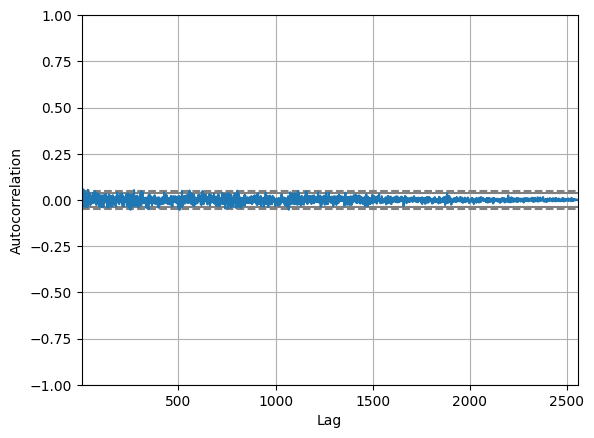

In [ ]:
autocorrelation_plot(Y_train)

In [ ]:
model_arima = ARIMA(endog=Y_train, exog=X_train, order=(0,1,7))

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:      daily_log_returns   No. Observations:                 1461
Model:                 ARIMA(0, 1, 7)   Log Likelihood                2897.878
Date:                Fri, 05 May 2023   AIC                          -5713.756
Time:                        16:45:43   BIC                          -5497.022
Sample:                    01-01-2018   HQIC                         -5632.905
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Close                              -4.341e-06   3.51e-22  -1.24e+16      0.000   -4.34e-06   -4.34e-06
daily_volatility                     3.05e-05   2.36e-24   

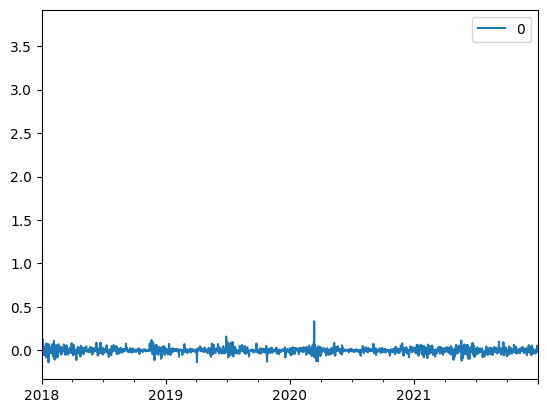

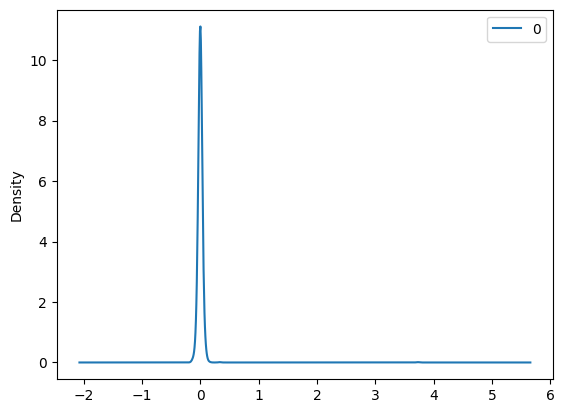

                 0
count  1461.000000
mean      0.001842
std       0.103025
min      -0.140100
25%      -0.016556
50%      -0.000544
75%       0.014179
max       3.726700


In [ ]:
model_fit = model_arima.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [ ]:
Y_pred_ARIMA = model_fit.forecast(exog=X_test, steps=X_test.shape[0])

In [ ]:
r2_score(Y_test, Y_pred_ARIMA)

-95948080.25930463

### Regressions

**Random Forest Regression**

In [20]:
# Grid-Search for Best Parameters
"""
PARAMS_GS_RFR = {
    "n_estimators": [100, 1000, 5000],
    "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    "max_depth": [None],
    "max_features": ["sqrt", "log2", None],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10],
}

rfr = RandomForestReg({})
rfr.grid_search_CV(
    X_train=X_train, 
    Y_train=Y_train,
    param_grid=PARAMS_GS_RFR,
    cv=None, 
    refit=True,
    scoring='r2', 
    n_jobs=-1, 
    verbose=5,
)
"""

'\nPARAMS_GS_RFR = {\n    "n_estimators": [100, 1000, 5000],\n    "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],\n    "max_depth": [None],\n    "max_features": ["sqrt", "log2", None],\n    "min_samples_leaf": [1, 2, 4],\n    "min_samples_split": [2, 5, 10],\n}\n\nrfr = RandomForestReg({})\nrfr.grid_search_CV(\n    X_train=X_train, \n    Y_train=Y_train,\n    param_grid=PARAMS_GS_RFR,\n    cv=None, \n    refit=True,\n    scoring=\'r2\', \n    n_jobs=-1, \n    verbose=5,\n)\n'

In [19]:
PARAMS_RFR = {
    "n_estimators": 100,
    "criterion": "squared_error",
    "max_depth": None,
    "max_features": None,
    "min_samples_leaf": 1,
}

rfr = RandomForestReg(**PARAMS_RFR)
rfr.fit_regressor(X_train, Y_train)
# make the prediction on the test set
Y_pred = rfr.predict_regressor(X_test)
# make the prediction on the out-of-sampling set
Y_pred_oos = rfr.predict_regressor(X_oos)
rfr.score_regressor(X_test, Y_test)

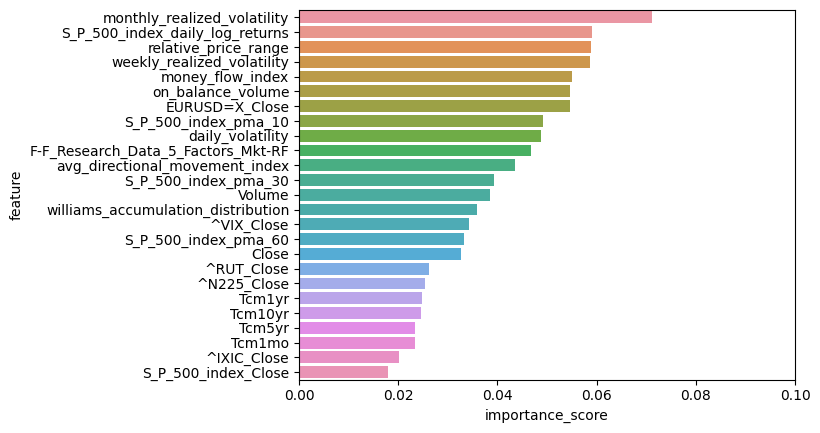

In [20]:
df_feat_imp = pd.DataFrame(
    [X_train.columns, rfr.regressor.feature_importances_], 
    index=["feature", "importance_score"]
    ).T.sort_values(by="importance_score", ascending=False)
sns.barplot(x=df_feat_imp["importance_score"], y=df_feat_imp["feature"], orient="horizonal")
plt.xlim(0, 0.1)
plt.show()

**Histogram Gradient Boosting Regressor**

In [21]:
PARAMS_HGBR = {
    "loss": "squared_error",
    "max_depth": None,
    "validation_fraction": 0.2,
}

hgbr = HistGradientBoostingReg(**PARAMS_HGBR)
hgbr.fit_regressor(X_train, Y_train)
Y_pred = hgbr.predict_regressor(X_test)
hgbr.score_regressor(X_test, Y_test)

**Stochastic Gradient Descent Regressor**

In [114]:
PARAMS_SGDR = {
    "loss": "squared_error",#"squared_error",
    "max_iter": 100,
    "penalty": "l2",
    "validation_fraction": 0.2,
    "early_stopping": True,
    "n_iter_no_change": 10,
    "learning_rate": "optimal",
}

sgdr = SGDReg(scaler="StandardScaler", **PARAMS_SGDR)
sgdr.fit_regressor(X_train, Y_train)
Y_pred = sgdr.predict_regressor(X_test)
sgdr.score_regressor(X_test, Y_test)

**Elastic Net Regressor**

In [ ]:
PARAMS_ENR = {
    # "loss": "squared_error",
    # "max_depth": None,
    # "validation_fraction": 0.2,
}

enr = ElasticNetReg(**PARAMS_ENR)
enr.fit_regressor(X_train, Y_train)
Y_pred = enr.predict_regressor(X_test)
enr.score_regressor(X_test, Y_test)

**ThielSen Regressor**

In [ ]:
PARAMS_TSR = {
    # "loss": "squared_error",
    # "max_depth": None,
    # "validation_fraction": 0.2,
}

tsr = TheilSenReg(**PARAMS_TSR)
tsr.fit_regressor(X_train, Y_train)
Y_pred = tsr.predict_regressor(X_test)
tsr.score_regressor(X_test, Y_test)

**RANSAC Regressor**

In [ ]:
PARAMS_RANSACR = {
    # "loss": "squared_error",
    # "max_depth": None,
    # "validation_fraction": 0.2,
}

ransacr = RANSACReg(**PARAMS_RANSACR)
ransacr.fit_regressor(X_train, Y_train)
Y_pred = ransacr.predict_regressor(X_test)
ransacr.score_regressor(X_test, Y_test)

## Plot Prediction

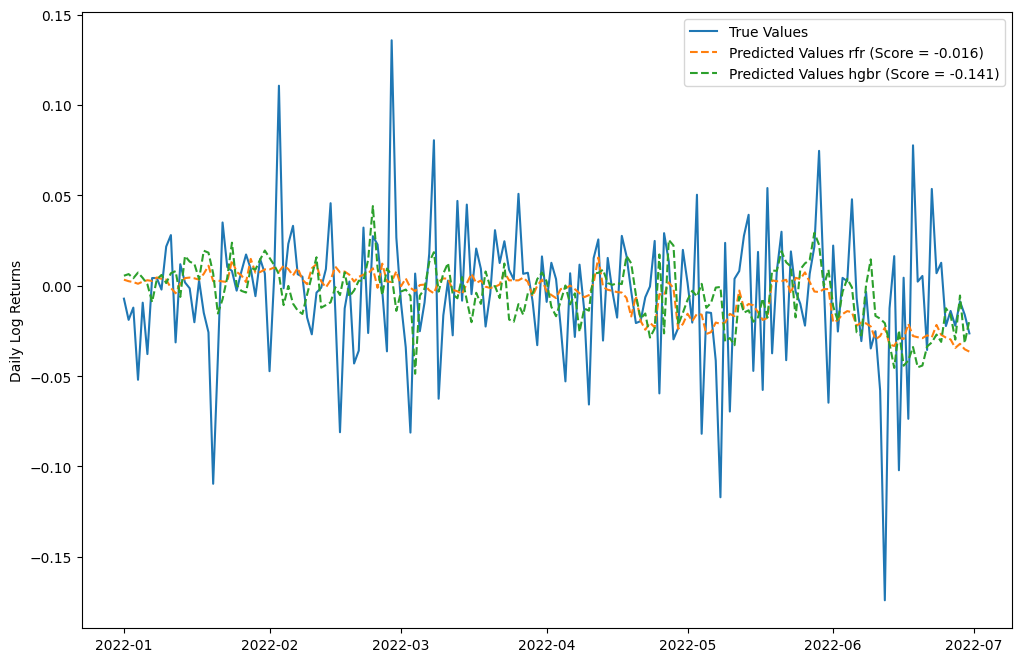

In [22]:
## Rest of the models are not good :(\

dict_regressors = {
    "rfr": rfr, 
    "hgbr": hgbr, 
    # "sgdr": sgdr, 
    # "enr": enr, 
    # "tsr": tsr, 
    # "ransacr": ransacr,
}

plt.figure(figsize=(12, 8))

PLOT_RANGE = ("2022-01-01", "2022-12-31")

plt.plot(Y_test[PLOT_RANGE[0]: PLOT_RANGE[1]], label="True Values")

for regressor_name, regressor in dict_regressors.items():
    # if regressor_name=='sgdr':
    #     continue
    plt.plot(
        regressor.predict_regressor(X_test)[PLOT_RANGE[0]: PLOT_RANGE[1]],
        label=f"Predicted Values {regressor_name} (Score = {round(regressor.score, 3)})",
        ls='--',
    )

# plt.plot(
#     Y_pred_ARIMA[PLOT_RANGE[0]: PLOT_RANGE[1]],
#     label=f"Predicted Values ARIMA (Score = {r2_score(Y_test, Y_pred_ARIMA)})",
#     ls='--'
#     )
# plt.title(f"Score= {round(rfr.score, 3)}")
plt.ylabel("Daily Log Returns")
plt.legend()
plt.show()

# Test Set

## Trading Strategy

In [23]:
# initialize this as the object of the chosen regression model
regression_model = rfr
# select the appropriate set to evaluate on
VALIDATIION_SET = 'test' # 'test' or 'out-of-sampling'

In [24]:
if VALIDATIION_SET == 'test':
    ds_daily_log_returns_pred = regression_model.predict_regressor(X_test)
    ds_daily_log_returns_true = Y_test
elif VALIDATIION_SET == 'out-of-sampling':
    ds_daily_log_returns_pred = regression_model.predict_regressor(X_oos)
    ds_daily_log_returns_true = Y_oos

**Trading Strategy from chosen regression model**

In [57]:
price_var='Close'
price_n_1 = df_asset[price_var][ds_daily_log_returns_pred.index[0] - pd.Timedelta('1D')]

ds_close_pred = regression_model.calc_price_from_daily_log_returns(ds_daily_log_returns_pred, price_n_1, price_var=price_var)
regression_trading_strategy = TradingStrategy(ds_daily_log_returns_pred, ds_close_pred)

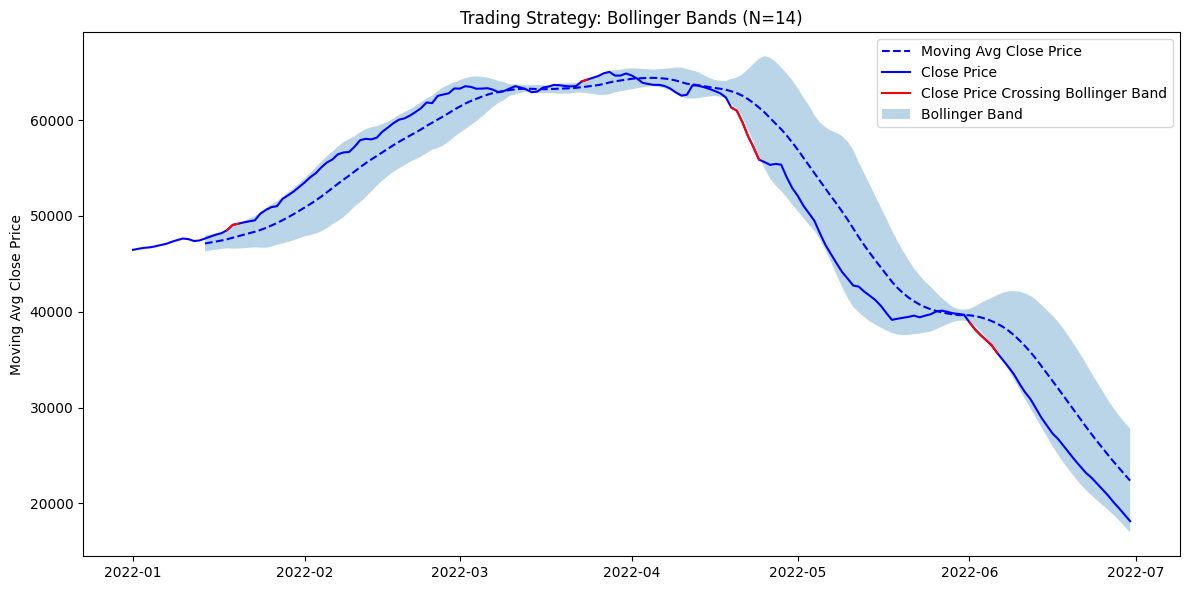

In [101]:
regression_trading_strategy.plot_strategy_bollinger_bands_N(14)

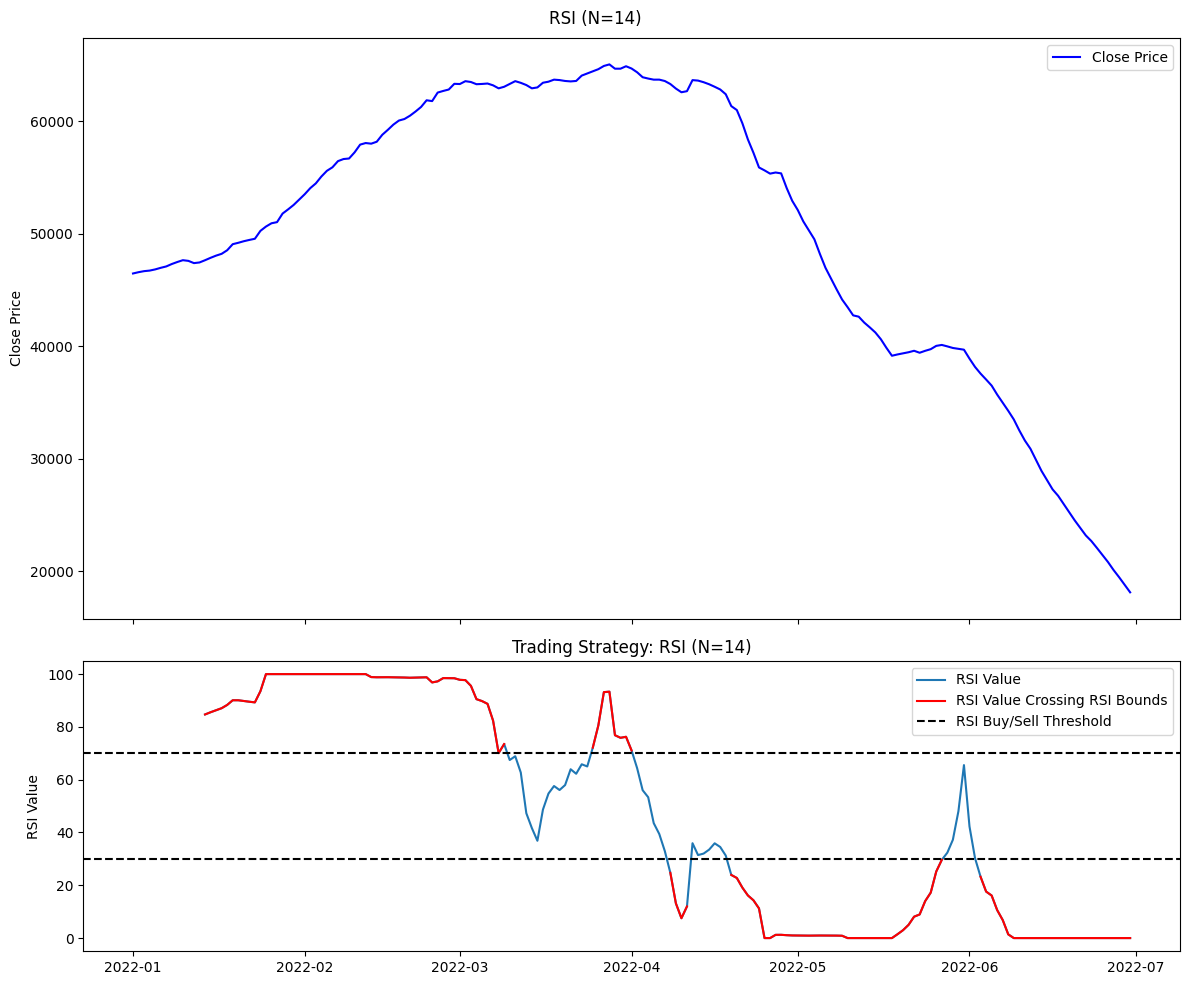

In [103]:
regression_trading_strategy.plot_strategy_relative_strength_index_N(14)

**Trading Strategy from True Values**

In [70]:
if VALIDATIION_SET == 'test':
    true_ts = TradingStrategy(Y_test, X_test['Close'])
elif VALIDATIION_SET == 'out-of-sampling':
    true_ts = TradingStrategy(Y_oos, X_oos['Close'])

## Compare Baseline

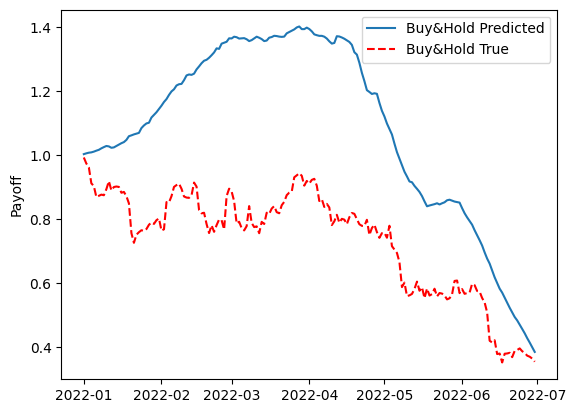

In [71]:
regression_baseline = regression_trading_strategy.strategy_buy_and_hold()
true_baseline = true_ts.strategy_buy_and_hold()

plt.plot(regression_baseline, label='Buy&Hold Predicted')
# plt.plot(df_rfr_payoffs['payoff_SMA_7'])
# ax2 = plt.twinx()
plt.plot(true_baseline, color='red', ls='--', label='Buy&Hold True')
plt.ylabel("Payoff")
plt.legend()
plt.show()

In [72]:
list_strategies = [
    'SMA_7', 'SMA_30', 'SMA_90', 'SMA_180', 
    'EMA_7', 'EMA_30', 'EMA_90', 'EMA_180', 
    'BBS_7', 'BBS_14', 'BBS_30', 
    'RSI_7', 'RSI_14', 'RSI_30',
    'SMA30_RSI14', 'EMA30_RSI14', 
    'EMA90_RSI14', 'SMA90_RSI14', 
    'SMA30_BBS7', 'EMA90_BBS7',
    ]

df_regression_payoffs = regression_trading_strategy.apply_strategy(list_strategies, return_payoff=True)

In [73]:
df_regression_payoffs[[col for col in df_regression_payoffs.columns if col.startswith("signal")]]

signal_SMA_7  signal_SMA_30  signal_SMA_90  signal_SMA_180  \
2022-01-01             0              0              0               0   
2022-01-02             0              0              0               0   
2022-01-03             0              0              0               0   
2022-01-04             0              0              0               0   
2022-01-05             0              0              0               0   
...                  ...            ...            ...             ...   
2022-06-26            -1             -1             -1               0   
2022-06-27            -1             -1             -1               0   
2022-06-28            -1             -1             -1               0   
2022-06-29            -1             -1             -1               0   
2022-06-30            -1             -1             -1              -1   

            signal_EMA_7  signal_EMA_30  signal_EMA_90  signal_EMA_180  \
2022-01-01             0              0              0               0   
2022-01-02             1              1              1               1   
2022-01-03             1              1              1               1   
2022-01-04             1              1              1               1   
2022-01-05             1              1              1               1   
...                  ...            ...            ...             ...   
2022-06-26            -1             -1             -1              -1   
2022-06-27            -1             -1             -1              -1   
2022-06-28            -1             -1             -1              -1   
2022-06-29            -1             -1             -1              -1   
2022-06-30            -1             -1             -1              -1   

            signal_BBS_7  signal_BBS_14  signal_BBS_30  signal_RSI_7  \
2022-01-01             0              0              0             0   
2022-01-02             0              0              0             0   
2022-01-03             0              0              0             0   
2022-01-04             0              0              0             0   
2022-01-05             0              0              0             0   
...                  ...            ...            ...           ...   
2022-06-26             0              0              0             1   
2022-06-27             0              0              0             1   
2022-06-28             0              0              0             1   
2022-06-29             0              0              0             1   
2022-06-30             0              0              0             1   

            signal_RSI_14  signal_RSI_30  signal_SMA30_RSI14  \
2022-01-01              0              0                   0   
2022-01-02              0              0                   0   
2022-01-03              0              0                   0   
2022-01-04              0              0                   0   
2022-01-05              0              0                   0   
...                   ...            ...                 ...   
2022-06-26              1              1                   0   
2022-06-27              1              1                   0   
2022-06-28              1              1                   0   
2022-06-29              1              1                   0   
2022-06-30              1              1                   0   

            signal_EMA30_RSI14  signal_EMA90_RSI14  signal_SMA90_RSI14  \
2022-01-01                   0                   0                   0   
2022-01-02                   1                   1                   0   
2022-01-03                   1                   1                   0   
2022-01-04                   1                   1                   0   
2022-01-05                   1                   1                   0   
...                        ...                 ...                 ...   
2022-06-26                   0                   0                   0   
2022-06-

In [74]:
list_strategies = [
    'SMA_7', 'SMA_30', 'SMA_90', 'SMA_180', 
    'EMA_7', 'EMA_30', 'EMA_90', 'EMA_180', 
    'BBS_7', 'BBS_14', 'BBS_30', 
    'RSI_7', 'RSI_14', 'RSI_30',
    'SMA30_RSI14', 'EMA30_RSI14', 
    'EMA90_RSI14', 'SMA90_RSI14', 
    'SMA30_BBS7', 'EMA90_BBS7',
    ]

df_true_payoffs = true_ts.apply_strategy(list_strategies, return_payoff=True)

In [75]:
df_true_payoffs#[[col for col in df_true_payoffs.columns if col.startswith("payoff")]]

signal_SMA_7  payoff_SMA_7  signal_SMA_30  payoff_SMA_30  \
2022-01-01             0      1.000000              0       1.000000   
2022-01-02             0      1.000000              0       1.000000   
2022-01-03             0      1.000000              0       1.000000   
2022-01-04             0      1.000000              0       1.000000   
2022-01-05             0      1.000000              0       1.000000   
...                  ...           ...            ...            ...   
2022-06-26             1      0.438363             -1       0.816595   
2022-06-27            -1      0.448085             -1       0.834707   
2022-06-28            -1      0.452004             -1       0.842008   
2022-06-29            -1      0.459241             -1       0.855488   
2022-06-30            -1      0.471362             -1       0.878067   

            signal_SMA_90  payoff_SMA_90  signal_SMA_180  payoff_SMA_180  \
2022-01-01              0       1.000000               0        1.000000   
2022-01-02              0       1.000000               0        1.000000   
2022-01-03              0       1.000000               0        1.000000   
2022-01-04              0       1.000000               0        1.000000   
2022-01-05              0       1.000000               0        1.000000   
...                   ...            ...             ...             ...   
2022-06-26             -1       1.446991               0        1.000000   
2022-06-27             -1       1.479085               0        1.000000   
2022-06-28             -1       1.492021               0        1.000000   
2022-06-29             -1       1.515908               0        1.000000   
2022-06-30             -1       1.555919              -1        1.026394   

            signal_EMA_7  payoff_EMA_7  signal_EMA_30  payoff_EMA_30  \
2022-01-01             0      1.000000              0       1.000000   
2022-01-02            -1      1.018915             -1       1.018915   
2022-01-03            -1      1.031283             -1       1.031283   
2022-01-04            -1      1.084978             -1       1.084978   
2022-01-05            -1      1.095188             -1       1.095188   
...                  ...           ...            ...            ...   
2022-06-26            -1      0.669730             -1       1.513947   
2022-06-27            -1      0.684585             -1       1.547526   
2022-06-28            -1      0.690573             -1       1.561062   
2022-06-29            -1      0.701628             -1       1.586054   
2022-06-30            -1      0.720147             -1       1.627915   

            signal_EMA_90  payoff_EMA_90  signal_EMA_180  payoff_EMA_180  \
2022-01-01              0       1.000000               0        1.000000   
2022-01-02             -1       1.018915              -1        1.018915   
2022-01-03             -1       1.031283              -1        1.031283   
2022-01-04             -1       1.084978              -1        1.084978   
2022-01-05             -1       1.095188              -1        1.095188   
...                   ...            ...             ...             ...   
2022-06-26             -1       1.542151              -1        1.908961   
2022-06-27             -1       1.576356              -1        1.951301   
2022-06-28             -1       1.590143              -1        1.968368   
2022-06-29             -1       1.615601              -1        1.999881   
2022-06-30             -1       1.658243              -1        2.052665   

            signal_BBS_7  payoff_BBS_7  signal_BBS_14  payoff_BBS_14  \
2022-01-01             0        1.0000              0       1.000000   
2022-01-02             0        1.0000              0       1.000000   
2022-01-03             0        1.0000              0       1.000000   
2022-01-04             0        1.0000              0       1.000000   
2022-01-05             0        1.0000              0       1.000000   
...                  ...

## Performance

In [76]:
df_regression_signals_test = df_regression_payoffs[[col for col in df_regression_payoffs.columns if col.startswith("signal")]]
signal_buy_and_hold = pd.Series(
    data=[1]*len(df_regression_signals_test), 
    index=df_regression_signals_test.index,
    name="signal_buy_and_hold", 
    )
df_regression_signals_test = pd.concat([signal_buy_and_hold, df_regression_signals_test], axis=1)
perf_m = PerformanceMetrics(
    ds_daily_log_returns_true, 
    df_regression_signals_test,
)

In [77]:
performance_metrics = [
    'cumulative_return', 'annualized_return', 'average_daily_log_returns', 
    'annualized_volatility', 'sharpe_ratio', 'annualized_sharpe_ratio', 
    'sortino_ratio', 'max_drawdown', 'calmar_ratio',
    ]

df_performance_metrics_last, df_performance_metrics = perf_m.compute_performance_metrics(performance_metrics)
df_performance_metrics_last

buy_and_hold     SMA_7    SMA_30    SMA_90  \
cumulative_return            -0.645517  1.158452  1.621026  0.715811   
annualized_return            -0.876483  3.718708  5.980372   1.97047   
average_daily_log_returns    -0.005006  0.004925  0.005942  0.003374   
annualized_volatility          0.71329  0.706633  0.675197  0.541445   
sharpe_ratio                  -0.13409  0.133169  0.168121  0.119052   
annualized_sharpe_ratio      -0.190416  0.189108  0.238742  0.169061   
sortino_ratio                -0.170854  0.225008  0.297259   0.21246   
max_drawdown                   2.28202  1.629722  1.467016  1.446147   
calmar_ratio                 -0.384082  2.281805  4.076556  1.362566   

                            SMA_180     EMA_7    EMA_30    EMA_90   EMA_180  \
cumulative_return          0.026394  0.718282  0.767369  0.589056  0.507159   
annualized_return          0.053939  1.979102  2.153216  1.544558  1.287025   
average_daily_log_returns  0.000146   0.00368  0.003835  0.003248  0.002956   
annualized_volatility      0.037481  0.716173  0.715876   0.71694  0.717404   
sharpe_ratio               0.074329  0.098182  0.102348  0.086565  0.078724   
annualized_sharpe_ratio    0.105552  0.139425   0.14534  0.122927  0.111793   
sortino_ratio                   inf  0.164627  0.175974  0.146352   0.13414   
max_drawdown                    1.0  1.629722  1.629722  1.629722  1.629722   
calmar_ratio               0.053939   1.21438  1.321217  0.947744  0.789721   

                              BBS_7    BBS_14    BBS_30     RSI_7    RSI_14  \
cumulative_return         -0.002957  0.135692 -0.500416 -0.658533 -0.597443   
annualized_return         -0.005953  0.292519  -0.75327 -0.885459 -0.840374   
average_daily_log_returns -0.000013  0.000752 -0.003576 -0.005263 -0.004392   
annualized_volatility      0.047162  0.193434  0.414917  0.682772  0.664416   
sharpe_ratio              -0.005396  0.074256 -0.164677 -0.147278 -0.126296   
annualized_sharpe_ratio   -0.007663  0.105447 -0.233852 -0.209144 -0.179348   
sortino_ratio             -0.007267  0.212234 -0.177039 -0.171191 -0.144636   
max_drawdown               2.108693  1.231425  3.241414  2.588003  2.588003   
calmar_ratio              -0.002823  0.237545 -0.232389  -0.34214 -0.324719   

                             RSI_30 SMA30_RSI14 EMA30_RSI14 EMA90_RSI14  \
cumulative_return         -0.660845    0.295493   -0.111379   -0.139958   
annualized_return         -0.887017    0.685518   -0.211897   -0.262174   
average_daily_log_returns -0.005348    0.001549   -0.000557   -0.000723   
annualized_volatility      0.655537    0.297453    0.263122    0.282703   
sharpe_ratio              -0.155873    0.099518   -0.040456   -0.048835   
annualized_sharpe_ratio   -0.221349    0.141321    -0.05745   -0.069348   
sortino_ratio             -0.176446    0.181464   -0.051891   -0.061058   
max_drawdown               3.141256    1.680557    2.152058    2.152058   
calmar_ratio              -0.282377    0.407911   -0.098462   -0.121825   

                          SMA90_RSI14 SMA30_BBS7 EMA90_BBS7  
cumulative_return           -0.154553   1.616145   0.586097  
annualized_return           -0.287205   5.954186   1.535013  
average_daily_log_returns   -0.000597   0.005928   0.003235  
annualized_volatility        0.488301   0.673591   0.715409  
sharpe_ratio                -0.023362   0.168144   0.086394  
annualized_sharpe_ratio     -0.033175   0.238775   0.122685  
sortino_ratio               -0.029592   0.296402   0.144701  
max_drawdown                 2.238672   1.467016   1.629722  
calmar_ratio                -0.128292   4.058706   0.941886

In [87]:
df_performance_metrics

cumulative_return_buy_and_hold  annualized_return_buy_and_hold  \
2022-01-01                       -0.007189                       -0.014444   
2022-01-02                       -0.025968                       -0.051675   
2022-01-03                       -0.037791                       -0.074746   
2022-01-04                       -0.087890                       -0.169323   
2022-01-05                       -0.096473                       -0.185011   
...                                    ...                             ...   
2022-06-26                       -0.618251                       -0.856575   
2022-06-27                       -0.626718                       -0.862918   
2022-06-28                       -0.629983                       -0.865325   
2022-06-29                       -0.635907                       -0.869638   
2022-06-30                       -0.645517                       -0.876483   

            average_daily_log_returns_buy_and_hold  \
2022-01-01                               -0.007189   
2022-01-02                               -0.013052   
2022-01-03                               -0.012748   
2022-01-04                               -0.022577   
2022-01-05                               -0.019944   
...                                            ...   
2022-06-26                               -0.004705   
2022-06-27                               -0.004803   
2022-06-28                               -0.004825   
2022-06-29                               -0.004887   
2022-06-30                               -0.005006   

            annualized_volatility_buy_and_hold  sharpe_ratio_buy_and_hold  \
2022-01-01                                 NaN                        NaN   
2022-01-02                            0.158404                  -1.574173   
2022-01-03                            0.112460                  -2.165579   
2022-01-04                            0.386653                  -1.115566   
2022-01-05                            0.353244                  -1.078649   
...                                        ...                        ...   
2022-06-26                            0.720050                  -0.124841   
2022-06-27                            0.718449                  -0.127729   
2022-06-28                            0.716450                  -0.128673   
2022-06-29                            0.714623                  -0.130663   
2022-06-30                            0.713290                  -0.134090   

            annualized_sharpe_ratio_buy_and_hold  sortino_ratio_buy_and_hold  \
2022-01-01                                   NaN                         NaN   
2022-01-02                             -2.235423                   -1.574173   
2022-01-03                             -3.075256                   -2.165579   
2022-01-04                             -1.584173                   -1.115566   
2022-01-05                             -1.531748                   -1.078649   
...                                          ...                         ...   
2022-06-26                             -0.177281                   -0.157836   
2022-06-27                             -0.181384                   -0.161959   
2022-06-28                             -0.182724                   -0.163120   
2022-06-29                             -0.185550                   -0.165915   
2022-06-30                             -0.190416                   -0.170854   

            max_drawdown_buy_and_hold  calmar_ratio_buy_and_hold  \
2022-01-01                  -0.000000                        inf   
2022-01-02                  -1.631033                   0.031682   
2022-01-03                  -1.631033                   0.045827   
2022-01-04                  -6.242439                   0.027124   
2022-01-05                  -6.242439                   0.029638   
...                               ...                        ...   
2022-06-26                   2.282020                  -0.375358

### Statistical Significance

In [104]:
STAT_SELECTED_METRICS = [
    'annualized_return', 
    'annualized_sharpe_ratio', 
    'max_drawdown',
    ]

STAT_REF_STRATEGY = "buy_and_hold"

STAT_SELECTED_STRATEGIES = [
    'SMA_7', 'SMA_30', 'SMA_90',
    'EMA_7', 'EMA_30', 'EMA_90', 
    'BBS_7', 'BBS_14', 'BBS_30', 
    'RSI_7', 'RSI_14', 'RSI_30',
    'SMA30_RSI14', 'EMA30_RSI14', 
    'EMA90_RSI14', 'SMA90_RSI14', 
    'SMA30_BBS7', 'EMA90_BBS7',
    ]

dict_stat_significance = {}

for metric in STAT_SELECTED_METRICS:
    for strategy in STAT_SELECTED_STRATEGIES:
        t_test_result = ttest_rel(
            df_performance_metrics[f"{metric}_{strategy}"],
            df_performance_metrics[f"{metric}_{STAT_REF_STRATEGY}"],
            nan_policy="omit",
            )
        dict_stat_significance[f"{metric}_{strategy}"] = t_test_result

        if t_test_result.pvalue > 0.05:
            print(f"{metric}_{strategy}", dict_stat_significance[f"{metric}_{strategy}"])

annualized_sharpe_ratio_BBS_7 TtestResult(statistic=1.0307013253758708, pvalue=0.30519239976788104, df=99)
annualized_sharpe_ratio_RSI_30 TtestResult(statistic=-1.845178739276225, pvalue=0.0669703340887344, df=151)


In [105]:
dict_stat_significance

{'annualized_return_SMA_7': TtestResult(statistic=9.115190674042008, pvalue=1.52961954137089e-16, df=180),
 'annualized_return_SMA_30': TtestResult(statistic=12.01216743675943, pvalue=8.646965089484509e-25, df=180),
 'annualized_return_SMA_90': TtestResult(statistic=12.209042753674769, pvalue=2.304104579044362e-25, df=180),
 'annualized_return_EMA_7': TtestResult(statistic=7.4872023516721775, pvalue=3.029312888147182e-12, df=180),
 'annualized_return_EMA_30': TtestResult(statistic=8.618062240460636, pvalue=3.4130781516068e-15, df=180),
 'annualized_return_EMA_90': TtestResult(statistic=8.10152718722198, pvalue=7.987406770213264e-14, df=180),
 'annualized_return_BBS_7': TtestResult(statistic=25.429158981668685, pvalue=1.7470811775839393e-61, df=180),
 'annualized_return_BBS_14': TtestResult(statistic=35.524659248869426, pvalue=2.950716806890598e-83, df=180),
 'annualized_return_BBS_30': TtestResult(statistic=13.214419185015075, pvalue=2.6354040904715355e-28, df=180),
 'annualized_return

### Plots to analyse trading strategies across performance metrics

**Comapre Cumulative Returns**

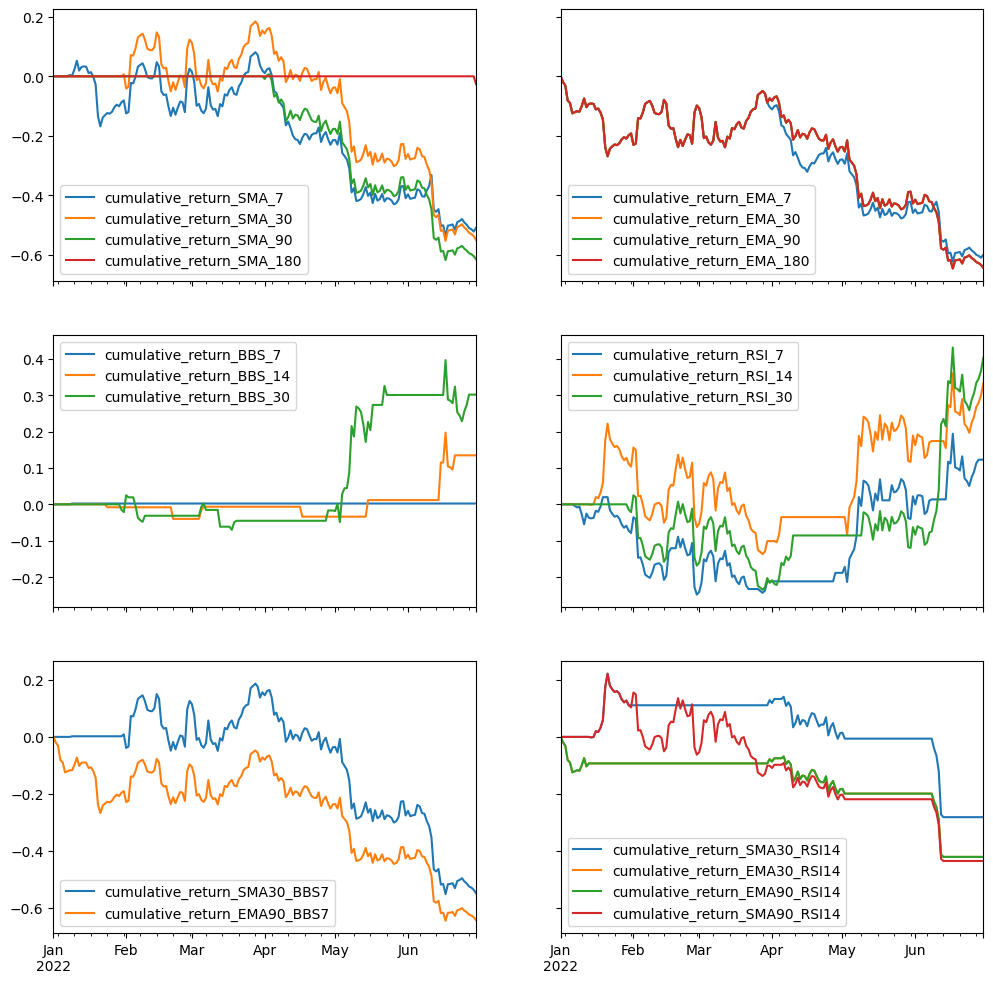

In [127]:
METRIC = 'cumulative_return'
STRATEGY_CATEGORIES = ['SMA', 'EMA', 'BBS', 'RSI', 'MA_BBS', 'MA_RSI']

nrows=3
ncols=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), sharey='row', sharex=True)
for i, strategy in enumerate(STRATEGY_CATEGORIES):
    ax = axs[i//ncols][i%ncols]
    if strategy not in ['MA_BBS', 'MA_RSI']:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and col.split("_")[-2]==strategy]]
    else:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and strategy.split("_")[-1] in col and 'MA' in col]]
    df_plot.plot(ax=ax)
plt.show()

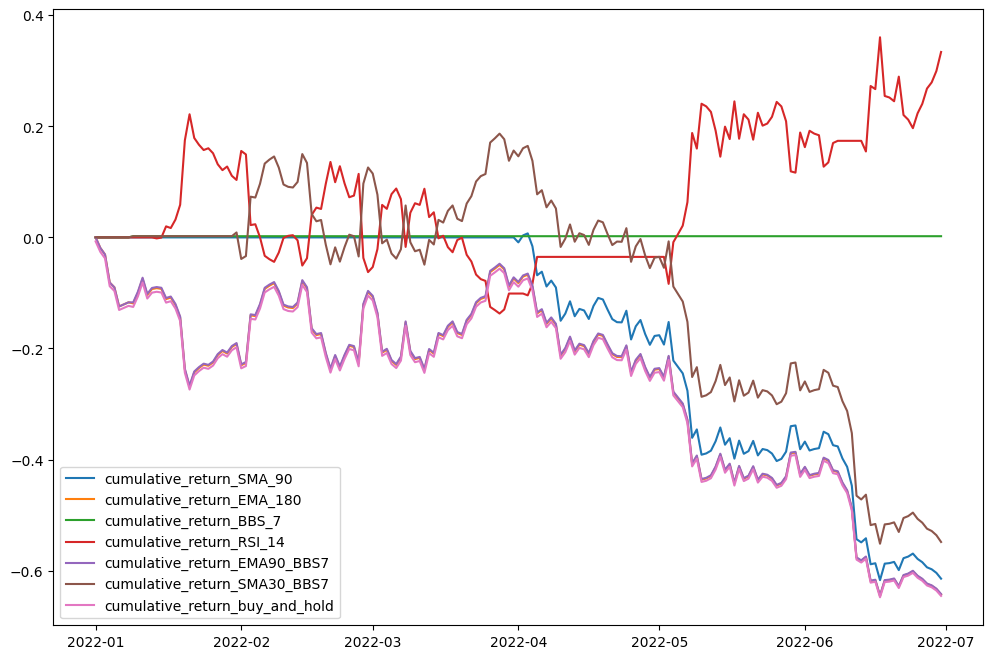

In [128]:
BEST_STRATEGIES = ['SMA_90', 'EMA_180', 'BBS_7', 'RSI_14', 'EMA90_BBS7', 'SMA30_BBS7', 'buy_and_hold']

nrows=1
ncols=1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey='row', sharex=True)
for strategy in BEST_STRATEGIES:
    ax.plot(df_performance_metrics[f'{METRIC}_{strategy}'], label=f"{METRIC}_{strategy}")
# ax.plot(regression_baseline-1, label=f"{metric}_buy_and_hold")
plt.legend()
plt.show()

**Compare Sharpe Ratio**

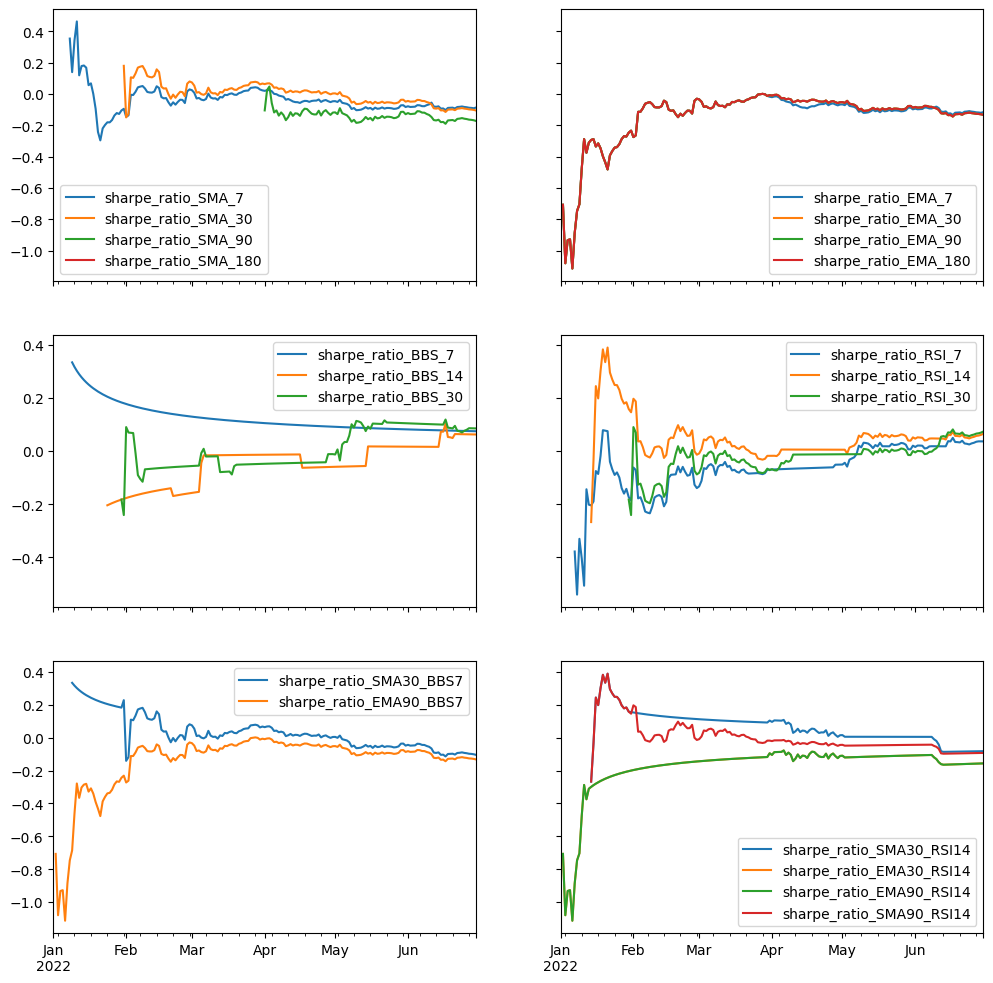

In [129]:
METRIC = 'sharpe_ratio'
STRATEGY_CATEGORIES = ['SMA', 'EMA', 'BBS', 'RSI', 'MA_BBS', 'MA_RSI']

nrows=3
ncols=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), sharey='row', sharex=True)
for i, strategy in enumerate(STRATEGY_CATEGORIES):
    ax = axs[i//ncols][i%ncols]
    if strategy not in ['MA_BBS', 'MA_RSI']:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and col.split("_")[-2]==strategy]]
    else:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and strategy.split("_")[-1] in col and 'MA' in col]]
    df_plot.plot(ax=ax)
plt.show()

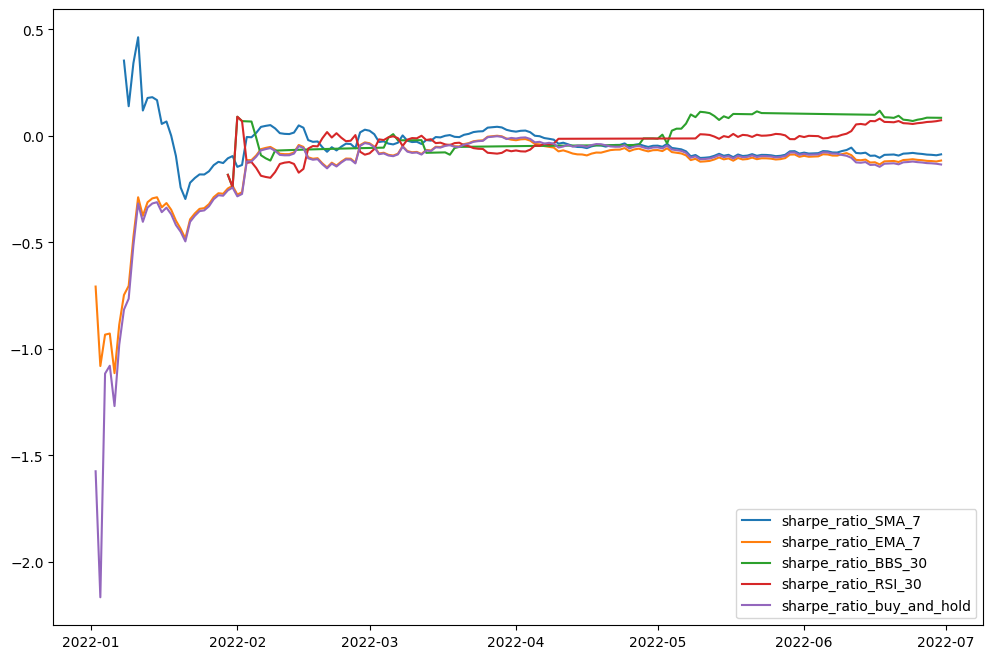

In [130]:
BEST_STRATEGIES = ['SMA_7', 'EMA_7', 'BBS_30', 'RSI_30', 'buy_and_hold']

nrows=1
ncols=1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey='row', sharex=True)
for strategy in BEST_STRATEGIES:
    plt.plot(df_performance_metrics[f'{METRIC}_{strategy}'], label=f"{METRIC}_{strategy}")
plt.legend()
plt.show()

# Out of Sampling Set

## Trading Strategy

In [131]:
# initialize this as the object of the chosen regression model
regression_model = hgbr
# select the appropriate set to evaluate on
VALIDATIION_SET = 'out-of-sampling' # 'test' or 'out-of-sampling'

In [132]:
if VALIDATIION_SET == 'test':
    ds_daily_log_returns_pred = regression_model.predict_regressor(X_test)
    ds_daily_log_returns_true = Y_test
elif VALIDATIION_SET == 'out-of-sampling':
    ds_daily_log_returns_pred = regression_model.predict_regressor(X_oos)
    ds_daily_log_returns_true = Y_oos

**Trading Strategy from chosen regression model**

In [133]:
price_var='Close'
price_n_1 = df_asset[price_var][ds_daily_log_returns_pred.index[0] - pd.Timedelta('1D')]

ds_close_pred = regression_model.calc_price_from_daily_log_returns(ds_daily_log_returns_pred, price_n_1, price_var=price_var)
regression_trading_strategy = TradingStrategy(ds_daily_log_returns_pred, ds_close_pred)

**Trading Strategy from True Values**

In [134]:
if VALIDATIION_SET == 'test':
    true_ts = TradingStrategy(Y_test, X_test['Close'])
elif VALIDATIION_SET == 'out-of-sampling':
    true_ts = TradingStrategy(Y_oos, X_oos['Close'])

## Compare Baseline

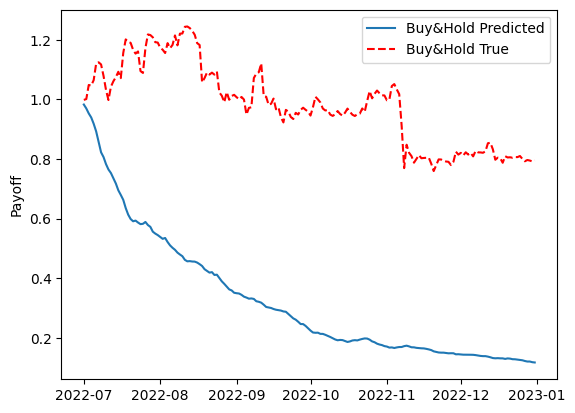

In [135]:
regression_baseline = regression_trading_strategy.strategy_buy_and_hold()
true_baseline = true_ts.strategy_buy_and_hold()

plt.plot(regression_baseline, label='Buy&Hold Predicted')
# plt.plot(df_rfr_payoffs['payoff_SMA_7'])
# ax2 = plt.twinx()
plt.plot(true_baseline, color='red', ls='--', label='Buy&Hold True')
plt.ylabel("Payoff")
plt.legend()
plt.show()

In [136]:
list_strategies = [
    'SMA_7', 'SMA_30', 'SMA_90', 'SMA_180', 
    'EMA_7', 'EMA_30', 'EMA_90', 'EMA_180', 
    'BBS_7', 'BBS_14', 'BBS_30', 
    'RSI_7', 'RSI_14', 'RSI_30',
    'SMA30_RSI14', 'EMA30_RSI14', 
    'EMA90_RSI14', 'SMA90_RSI14', 
    'SMA30_BBS7', 'EMA90_BBS7',
    ]

df_regression_payoffs = regression_trading_strategy.apply_strategy(list_strategies, return_payoff=True)

In [137]:
df_regression_payoffs#[[col for col in df_regression_payoffs.columns if col.startswith("signal")]]

signal_SMA_7  payoff_SMA_7  signal_SMA_30  payoff_SMA_30  \
2022-07-01             0      1.000000              0       1.000000   
2022-07-02             0      1.000000              0       1.000000   
2022-07-03             0      1.000000              0       1.000000   
2022-07-04             0      1.000000              0       1.000000   
2022-07-05             0      1.000000              0       1.000000   
...                  ...           ...            ...            ...   
2022-12-27            -1      7.648545             -1       4.367042   
2022-12-28            -1      7.759981             -1       4.430668   
2022-12-29            -1      7.757831             -1       4.429440   
2022-12-30            -1      7.902240             -1       4.511893   
2022-12-31            -1      7.967563             -1       4.549189   

            signal_SMA_90  payoff_SMA_90  signal_SMA_180  payoff_SMA_180  \
2022-07-01              0       1.000000               0        1.000000   
2022-07-02              0       1.000000               0        1.000000   
2022-07-03              0       1.000000               0        1.000000   
2022-07-04              0       1.000000               0        1.000000   
2022-07-05              0       1.000000               0        1.000000   
...                   ...            ...             ...             ...   
2022-12-27             -1       1.984445               0        1.000000   
2022-12-28             -1       2.013357              -1        1.014570   
2022-12-29             -1       2.012800              -1        1.014288   
2022-12-30             -1       2.050267              -1        1.033169   
2022-12-31             -1       2.067215              -1        1.041710   

            signal_EMA_7  payoff_EMA_7  signal_EMA_30  payoff_EMA_30  \
2022-07-01             0      1.000000              0       1.000000   
2022-07-02            -1      1.013358             -1       1.013358   
2022-07-03            -1      1.030875             -1       1.030875   
2022-07-04            -1      1.045525             -1       1.045525   
2022-07-05            -1      1.069043             -1       1.069043   
...                  ...           ...            ...            ...   
2022-12-27            -1      8.503469             -1       7.688213   
2022-12-28            -1      8.627362             -1       7.800227   
2022-12-29            -1      8.624971             -1       7.798066   
2022-12-30            -1      8.785522             -1       7.943224   
2022-12-31            -1      8.858146             -1       8.008886   

            signal_EMA_90  payoff_EMA_90  signal_EMA_180  payoff_EMA_180  \
2022-07-01              0       1.000000               0        1.000000   
2022-07-02             -1       1.013358              -1        1.013358   
2022-07-03             -1       1.030875              -1        1.030875   
2022-07-04             -1       1.045525              -1        1.045525   
2022-07-05             -1       1.069043              -1        1.069043   
...                   ...            ...             ...             ...   
2022-12-27             -1       7.688213              -1        7.688213   
2022-12-28             -1       7.800227              -1        7.800227   
2022-12-29             -1       7.798066              -1        7.798066   
2022-12-30             -1       7.943224              -1        7.943224   
2022-12-31             -1       8.008886              -1        8.008886   

            signal_BBS_7  payoff_BBS_7  signal_BBS_14  payoff_BBS_14  \
2022-07-01             0           1.0              0       1.000000   
2022-07-02             0           1.0              0       1.000000   
2022-07-03             0           1.0              0       1.000000   
2022-07-04             0           1.0              0       1.000000   
2022-07-05             0           1.0              0       1.000000   
...                  ...

In [138]:
list_strategies = [
    'SMA_7', 'SMA_30', 'SMA_90', 'SMA_180', 
    'EMA_7', 'EMA_30', 'EMA_90', 'EMA_180', 
    'BBS_7', 'BBS_14', 'BBS_30', 
    'RSI_7', 'RSI_14', 'RSI_30',
    'SMA30_RSI14', 'EMA30_RSI14', 
    'EMA90_RSI14', 'SMA90_RSI14', 
    'SMA30_BBS7', 'EMA90_BBS7',
    ]

df_true_payoffs = true_ts.apply_strategy(list_strategies, return_payoff=True)

In [139]:
df_true_payoffs#[[col for col in df_true_payoffs.columns if col.startswith("payoff")]]

signal_SMA_7  payoff_SMA_7  signal_SMA_30  payoff_SMA_30  \
2022-07-01             0      1.000000              0       1.000000   
2022-07-02             0      1.000000              0       1.000000   
2022-07-03             0      1.000000              0       1.000000   
2022-07-04             0      1.000000              0       1.000000   
2022-07-05             0      1.000000              0       1.000000   
...                  ...           ...            ...            ...   
2022-12-27            -1      0.763445             -1       0.774559   
2022-12-28            -1      0.759316             -1       0.770370   
2022-12-29            -1      0.761132             -1       0.772212   
2022-12-30            -1      0.763662             -1       0.774779   
2022-12-31            -1      0.760090             -1       0.771155   

            signal_SMA_90  payoff_SMA_90  signal_SMA_180  payoff_SMA_180  \
2022-07-01              0       1.000000               0        1.000000   
2022-07-02              0       1.000000               0        1.000000   
2022-07-03              0       1.000000               0        1.000000   
2022-07-04              0       1.000000               0        1.000000   
2022-07-05              0       1.000000               0        1.000000   
...                   ...            ...             ...             ...   
2022-12-27             -1       0.811262               0        1.000000   
2022-12-28             -1       0.806874              -1        0.994591   
2022-12-29             -1       0.808804              -1        0.996970   
2022-12-30             -1       0.811492              -1        1.000284   
2022-12-31             -1       0.807696              -1        0.995605   

            signal_EMA_7  payoff_EMA_7  signal_EMA_30  payoff_EMA_30  \
2022-07-01             0      1.000000              0       1.000000   
2022-07-02            -1      0.997155             -1       0.997155   
2022-07-03             1      1.044296              1       1.044296   
2022-07-04             1      1.042170              1       1.042170   
2022-07-05             1      1.060494              1       1.060494   
...                  ...           ...            ...            ...   
2022-12-27            -1      1.116459             -1       0.674273   
2022-12-28            -1      1.110420             -1       0.670626   
2022-12-29            -1      1.113076             -1       0.672230   
2022-12-30            -1      1.116775             -1       0.674464   
2022-12-31            -1      1.111552             -1       0.671309   

            signal_EMA_90  payoff_EMA_90  signal_EMA_180  payoff_EMA_180  \
2022-07-01              0       1.000000               0        1.000000   
2022-07-02             -1       0.997155              -1        0.997155   
2022-07-03              1       1.044296               1        1.044296   
2022-07-04              1       1.042170               1        1.042170   
2022-07-05              1       1.060494               1        1.060494   
...                   ...            ...             ...             ...   
2022-12-27             -1       0.756023              -1        0.772890   
2022-12-28             -1       0.751934              -1        0.768710   
2022-12-29             -1       0.753732              -1        0.770548   
2022-12-30             -1       0.756238              -1        0.773109   
2022-12-31             -1       0.752700              -1        0.769493   

            signal_BBS_7  payoff_BBS_7  signal_BBS_14  payoff_BBS_14  \
2022-07-01             0      1.000000              0       1.000000   
2022-07-02             0      1.000000              0       1.000000   
2022-07-03             0      1.000000              0       1.000000   
2022-07-04             0      1.000000              0       1.000000   
2022-07-05             0      1.000000              0       1.000000   
...                  ...

## Performance

In [140]:
df_regression_signals_oos = df_regression_payoffs[[col for col in df_regression_payoffs.columns if col.startswith("signal")]]
signal_buy_and_hold = pd.Series(
    data=[1]*len(df_regression_signals_oos), 
    index=df_regression_signals_oos.index,
    name="signal_buy_and_hold", 
    )
df_regression_signals_oos = pd.concat([signal_buy_and_hold, df_regression_signals_oos], axis=1)
perf_m = PerformanceMetrics(
    ds_daily_log_returns_true, 
    df_regression_signals_oos,
)

In [141]:
performance_metrics = [
    'cumulative_return', 'annualized_return', 'average_daily_log_returns', 
    'annualized_volatility', 'sharpe_ratio', 'annualized_sharpe_ratio', 
    'sortino_ratio', 'max_drawdown', 'calmar_ratio',
    ]

df_performance_metrics_last, df_performance_metrics = perf_m.compute_performance_metrics(performance_metrics)
df_performance_metrics_last

buy_and_hold     SMA_7    SMA_30    SMA_90  \
cumulative_return             -0.20404 -0.106943  0.319836  0.137362   
annualized_return            -0.364087 -0.200978  0.734103  0.290882   
average_daily_log_returns    -0.000802 -0.000192  0.001843  0.000887   
annualized_volatility         0.560943  0.551741  0.500072  0.376162   
sharpe_ratio                 -0.027322 -0.006645  0.070413  0.045059   
annualized_sharpe_ratio      -0.038481 -0.009359  0.099172  0.063463   
sortino_ratio                -0.033444 -0.007567  0.103861  0.068762   
max_drawdown                  2.517968  2.460855  1.658775  1.658775   
calmar_ratio                 -0.144595  -0.08167  0.442557  0.175359   

                            SMA_180     EMA_7    EMA_30    EMA_90   EMA_180  \
cumulative_return         -0.004395 -0.017808  0.070648  0.070648  0.070648   
annualized_return           -0.0087 -0.035015  0.145013  0.145013  0.145013   
average_daily_log_returns -0.000024  0.000336  0.000795  0.000795  0.000795   
annualized_volatility      0.011629  0.561113  0.560944  0.560944  0.560944   
sharpe_ratio              -0.039028  0.011426  0.027061  0.027061  0.027061   
annualized_sharpe_ratio   -0.054968  0.016093  0.038114  0.038114  0.038114   
sortino_ratio             -0.044939  0.014045  0.038094  0.038094  0.038094   
max_drawdown               2.627313  2.460855  1.658775  1.658775  1.658775   
calmar_ratio              -0.003311 -0.014229  0.087422  0.087422  0.087422   

                          BBS_7    BBS_14    BBS_30     RSI_7    RSI_14  \
cumulative_return           0.0 -0.057005  0.002501 -0.195661 -0.259229   
annualized_return           0.0 -0.109909  0.004968 -0.350739 -0.448567   
average_daily_log_returns   0.0 -0.000314  0.000014 -0.000829 -0.001242   
annualized_volatility       0.0  0.062416  0.003523  0.510689  0.526828   
sharpe_ratio                NaN -0.095973  0.073721 -0.031025 -0.045057   
annualized_sharpe_ratio     NaN -0.135172  0.103831 -0.043697  -0.06346   
sortino_ratio               NaN -0.099415       inf -0.042557 -0.054017   
max_drawdown                NaN  3.919502       1.0  1.684531  2.517968   
calmar_ratio                NaN -0.028042  0.004968 -0.208211 -0.178147   

                             RSI_30 SMA30_RSI14 EMA30_RSI14 EMA90_RSI14  \
cumulative_return         -0.253064    0.102293   -0.087638   -0.087638   
annualized_return         -0.439427    0.213122   -0.166349   -0.166349   
average_daily_log_returns -0.001339    0.000601   -0.000448   -0.000448   
annualized_volatility      0.420958     0.23066    0.191576    0.191576   
sharpe_ratio              -0.060749    0.049746   -0.044669   -0.044669   
annualized_sharpe_ratio   -0.085561    0.070064   -0.062913   -0.062913   
sortino_ratio             -0.071952    0.089005   -0.056615   -0.056615   
max_drawdown               2.051225    1.719157    2.184889    2.184889   
calmar_ratio              -0.214227    0.123969   -0.076136   -0.076136   

                          SMA90_RSI14 SMA30_BBS7 EMA90_BBS7  
cumulative_return           -0.101024   0.319836   0.070648  
annualized_return           -0.190438   0.734103   0.145013  
average_daily_log_returns   -0.000355   0.001843   0.000795  
annualized_volatility        0.403512   0.500072   0.560944  
sharpe_ratio                -0.016822   0.070413   0.027061  
annualized_sharpe_ratio     -0.023692   0.099172   0.038114  
sortino_ratio               -0.022116   0.103861   0.038094  
max_drawdown                 2.051225   1.658775   1.658775  
calmar_ratio                -0.092841   0.442557   0.087422

### Plots to analyse trading strategies across performance metrics

**Comapre Cumulative Returns**

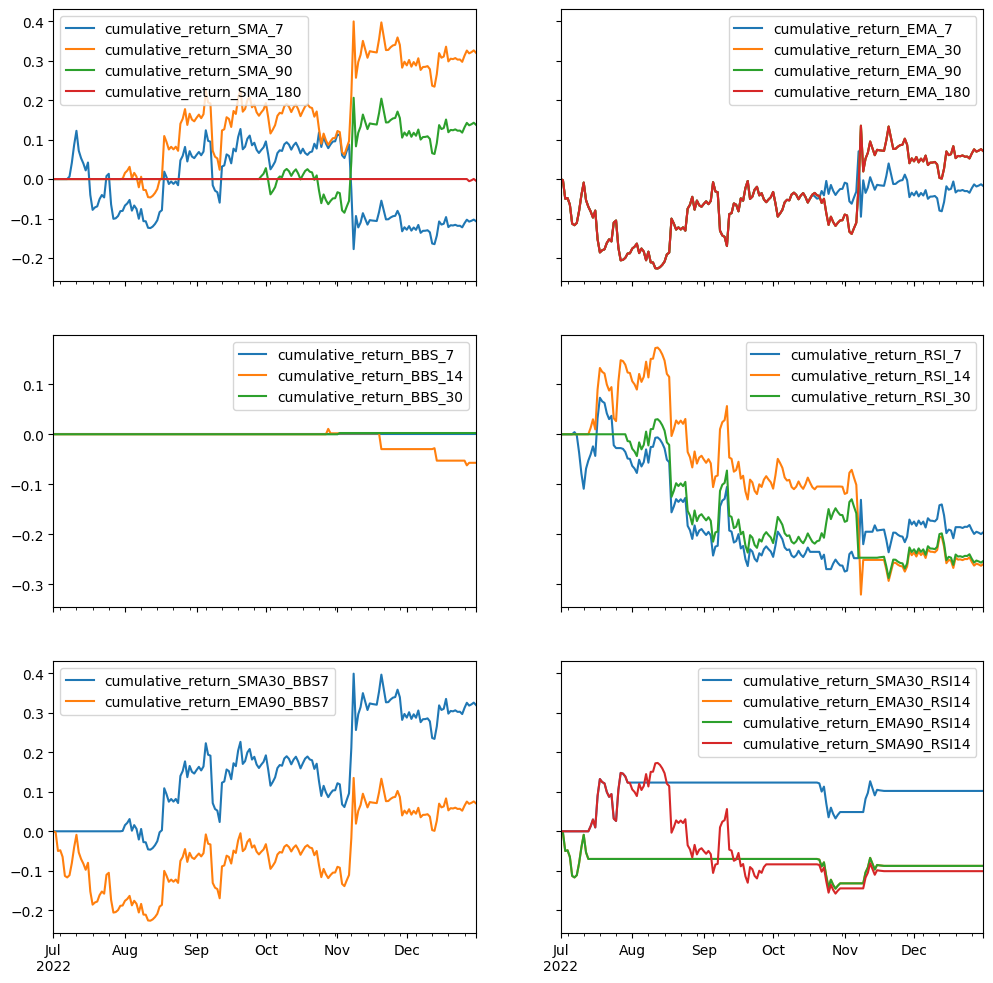

In [142]:
METRIC = 'cumulative_return'
STRATEGY_CATEGORIES = ['SMA', 'EMA', 'BBS', 'RSI', 'MA_BBS', 'MA_RSI']

nrows=3
ncols=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), sharey='row', sharex=True)
for i, strategy in enumerate(STRATEGY_CATEGORIES):
    ax = axs[i//ncols][i%ncols]
    if strategy not in ['MA_BBS', 'MA_RSI']:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and col.split("_")[-2]==strategy]]
    else:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and strategy.split("_")[-1] in col and 'MA' in col]]
    df_plot.plot(ax=ax)
plt.show()

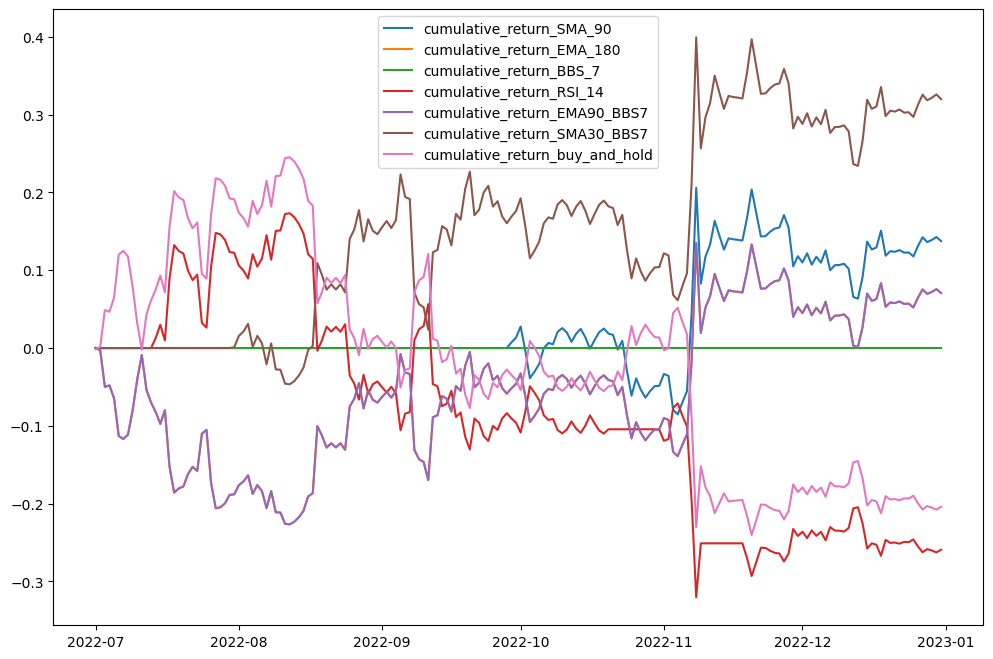

In [143]:
BEST_STRATEGIES = ['SMA_90', 'EMA_180', 'BBS_7', 'RSI_14', 'EMA90_BBS7', 'SMA30_BBS7', 'buy_and_hold']

nrows=1
ncols=1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey='row', sharex=True)
for strategy in BEST_STRATEGIES:
    ax.plot(df_performance_metrics[f'{METRIC}_{strategy}'], label=f"{METRIC}_{strategy}")
# ax.plot(regression_baseline-1, label=f"{metric}_buy_and_hold")
plt.legend()
plt.show()

**Compare Sharpe Ratio**

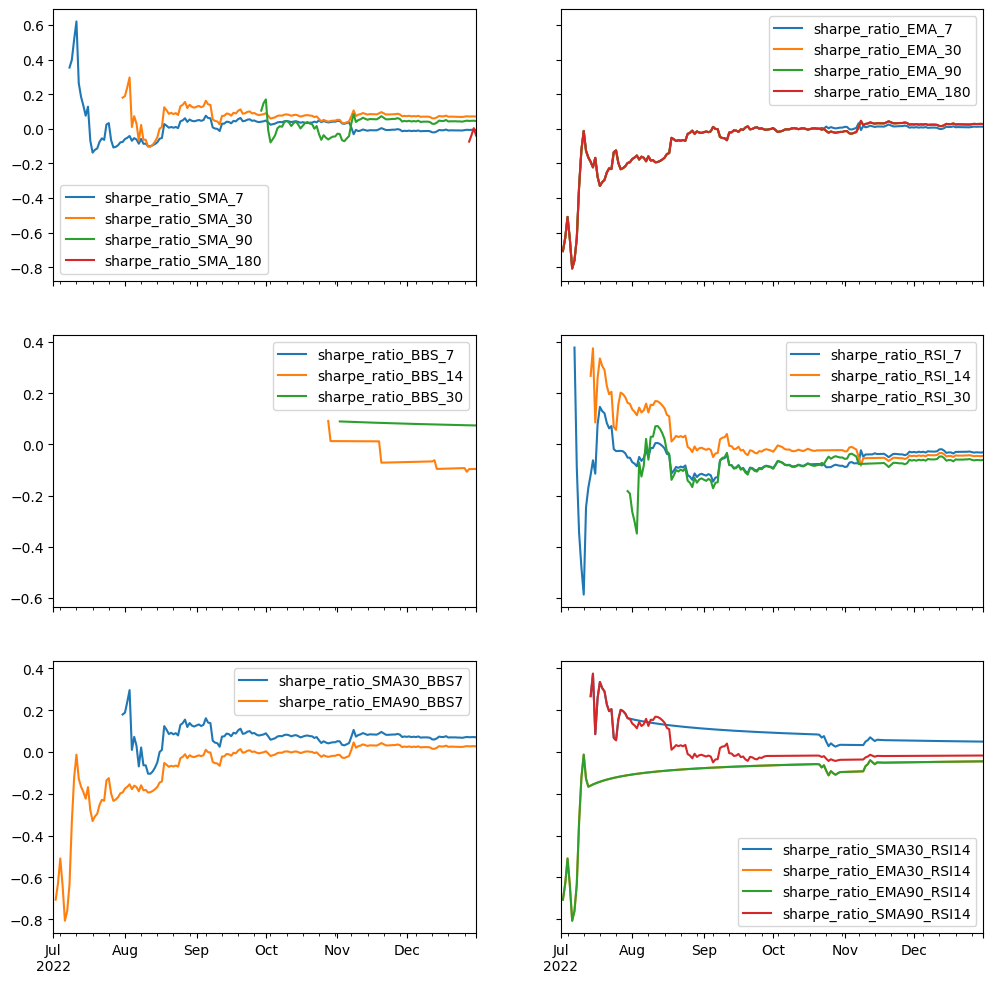

In [144]:
METRIC = 'sharpe_ratio'
STRATEGY_CATEGORIES = ['SMA', 'EMA', 'BBS', 'RSI', 'MA_BBS', 'MA_RSI']

nrows=3
ncols=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), sharey='row', sharex=True)
for i, strategy in enumerate(STRATEGY_CATEGORIES):
    ax = axs[i//ncols][i%ncols]
    if strategy not in ['MA_BBS', 'MA_RSI']:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and col.split("_")[-2]==strategy]]
    else:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and strategy.split("_")[-1] in col and 'MA' in col]]
    df_plot.plot(ax=ax)
plt.show()

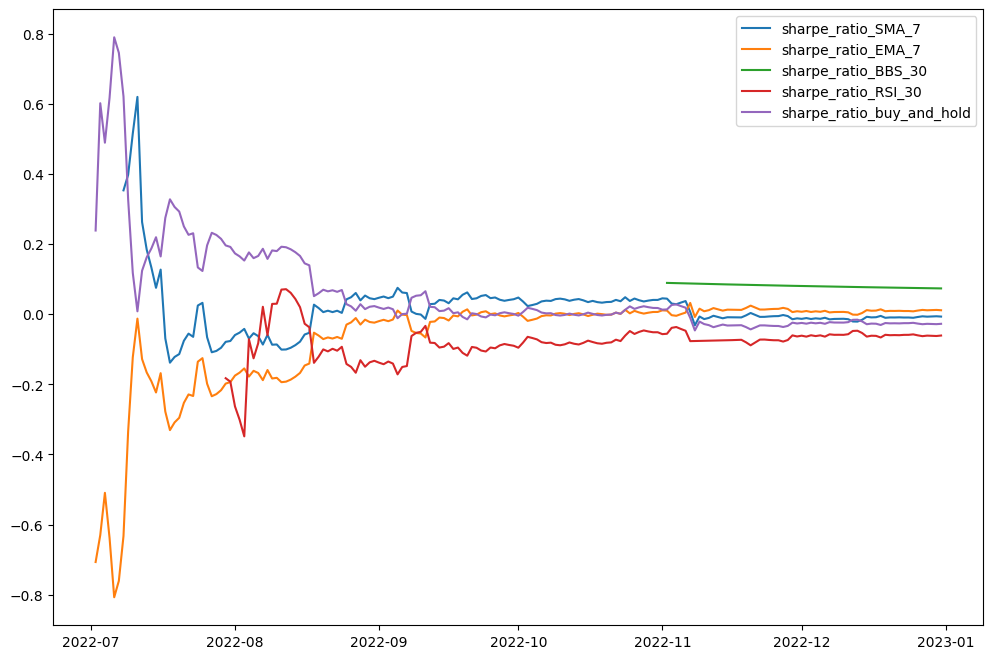

In [145]:
BEST_STRATEGIES = ['SMA_7', 'EMA_7', 'BBS_30', 'RSI_30', 'buy_and_hold']

nrows=1
ncols=1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey='row', sharex=True)
for strategy in BEST_STRATEGIES:
    plt.plot(df_performance_metrics[f'{METRIC}_{strategy}'], label=f"{METRIC}_{strategy}")
plt.legend()
plt.show()

# Robustness Test

## Trading Strategy

In [60]:
# initialize this as the object of the chosen regression model
regression_model = rfr
# select the name of target asset to evaluate on
ROBUSTNESS_SET = 'ETH-USD' # 'ETH-USD'

df_asset_val = dict_assets[ROBUSTNESS_SET][TEST_DATE_RANGE[0]: TEST_DATE_RANGE[1]]

X_rob, Y_rob = df_asset_val[FEATURES_LIST_HAND_PICKED], df_asset_val[TARGET]

ds_daily_log_returns_true = Y_rob

## Performance

In [61]:
perf_m = PerformanceMetrics(
    ds_daily_log_returns_true, 
    df_regression_signals_test,
)

In [62]:
performance_metrics = [
    'cumulative_return', 'annualized_return', 'average_daily_log_returns', 
    'annualized_volatility', 'sharpe_ratio', 'annualized_sharpe_ratio', 
    'sortino_ratio', 'max_drawdown', 'calmar_ratio',
    ]

df_performance_metrics_last, df_performance_metrics = perf_m.compute_performance_metrics(performance_metrics)
df_performance_metrics_last

buy_and_hold     SMA_7    SMA_30    SMA_90  \
cumulative_return            -0.779863  0.443402   1.81837  0.785294   
annualized_return            -0.779863  0.443402   1.81837  0.785294   
average_daily_log_returns    -0.003079  0.002025  0.003786  0.002412   
annualized_volatility         0.871352  0.865746  0.835119   0.77971   
sharpe_ratio                 -0.067519  0.044688  0.086623  0.059103   
annualized_sharpe_ratio      -0.067519  0.044688  0.086623  0.059103   
sortino_ratio                -0.088357  0.066204  0.128466    0.0839   
max_drawdown                  2.152302  1.867828  1.867828  1.867828   
calmar_ratio                 -0.362339  0.237389  0.973521  0.420432   

                            SMA_180     EMA_7    EMA_30    EMA_90   EMA_180  \
cumulative_return         -0.236778  0.225344  0.630054  0.438848  0.311229   
annualized_return         -0.236778  0.225344  0.630054  0.438848  0.311229   
average_daily_log_returns -0.000234  0.001592  0.002373  0.002032  0.001778   
annualized_volatility      0.608843  0.872497  0.871847  0.872162  0.872366   
sharpe_ratio              -0.007331  0.034861  0.052008  0.044517  0.038935   
annualized_sharpe_ratio   -0.007331  0.034861  0.052008  0.044517  0.038935   
sortino_ratio             -0.009729  0.052474  0.077611  0.066192  0.058204   
max_drawdown               1.867828  1.867828  1.867828  1.867828  1.867828   
calmar_ratio              -0.126767  0.120645  0.337319  0.234951  0.166626   

                              BBS_7  ...    BBS_30     RSI_7    RSI_14  \
cumulative_return         -0.081173  ... -0.659513 -0.646212 -0.745976   
annualized_return         -0.081173  ... -0.659513 -0.646212 -0.745976   
average_daily_log_returns -0.000226  ...  -0.00278 -0.001837  -0.00277   
annualized_volatility      0.065926  ...  0.336135  0.850742  0.838289   
sharpe_ratio              -0.065414  ... -0.158018 -0.041243 -0.063124   
annualized_sharpe_ratio   -0.065414  ... -0.158018 -0.041243 -0.063124   
sortino_ratio             -0.065414  ... -0.161152 -0.053352 -0.080875   
max_drawdown                   -inf  ...  5.562387  2.152302  2.152302   
calmar_ratio                    0.0  ... -0.118567 -0.300242 -0.346595   

                             RSI_30 SMA30_RSI14 EMA30_RSI14 EMA90_RSI14  \
cumulative_return         -0.786377    0.395174   -0.159261   -0.202943   
annualized_return         -0.786377    0.395174   -0.159261   -0.202943   
average_daily_log_returns -0.003274    0.001017   -0.000396   -0.000533   
annualized_volatility      0.823244    0.279974    0.237874    0.251576   
sharpe_ratio              -0.075988    0.069378   -0.031838   -0.040475   
annualized_sharpe_ratio   -0.075988    0.069378   -0.031838   -0.040475   
sortino_ratio              -0.09628    0.126444   -0.039312   -0.048792   
max_drawdown               2.152302    1.606546    2.536149    2.536149   
calmar_ratio              -0.365366    0.245978   -0.062796    -0.08002   

                          SMA90_RSI14 SMA30_BBS7 EMA90_BBS7  
cumulative_return           -0.124262   1.600913    0.32783  
annualized_return           -0.124262   1.600913    0.32783  
average_daily_log_returns   -0.000153   0.003561   0.001807  
annualized_volatility        0.392395   0.832866   0.869838  
sharpe_ratio                -0.007455   0.081679   0.039678  
annualized_sharpe_ratio     -0.007455   0.081679   0.039678  
sortino_ratio               -0.010238   0.120961   0.058795  
max_drawdown                 1.673536   1.867828   1.867828  
calmar_ratio                -0.074251   0.857098   0.175514  

[9 rows x 21 columns]

### Plots to analyse trading strategies across performance metrics

**Comapre Cumulative Returns**

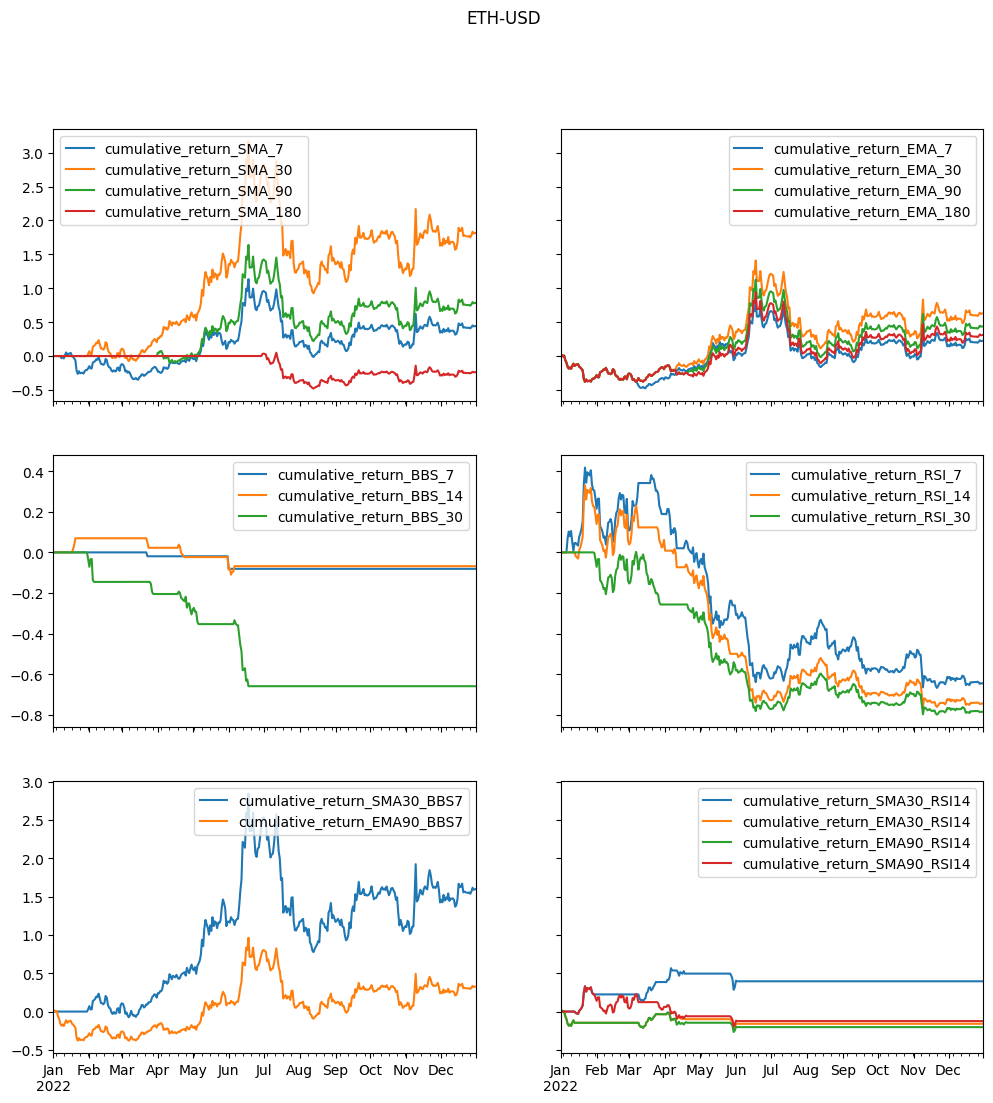

In [63]:
METRIC = 'cumulative_return'
STRATEGY_CATEGORIES = ['SMA', 'EMA', 'BBS', 'RSI', 'MA_BBS', 'MA_RSI']

nrows=3
ncols=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), sharey='row', sharex=True)
for i, strategy in enumerate(STRATEGY_CATEGORIES):
    ax = axs[i//ncols][i%ncols]
    if strategy not in ['MA_BBS', 'MA_RSI']:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and col.split("_")[-2]==strategy]]
    else:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and strategy.split("_")[-1] in col and 'MA' in col]]
    df_plot.plot(ax=ax)
plt.suptitle(ROBUSTNESS_SET)
plt.show()

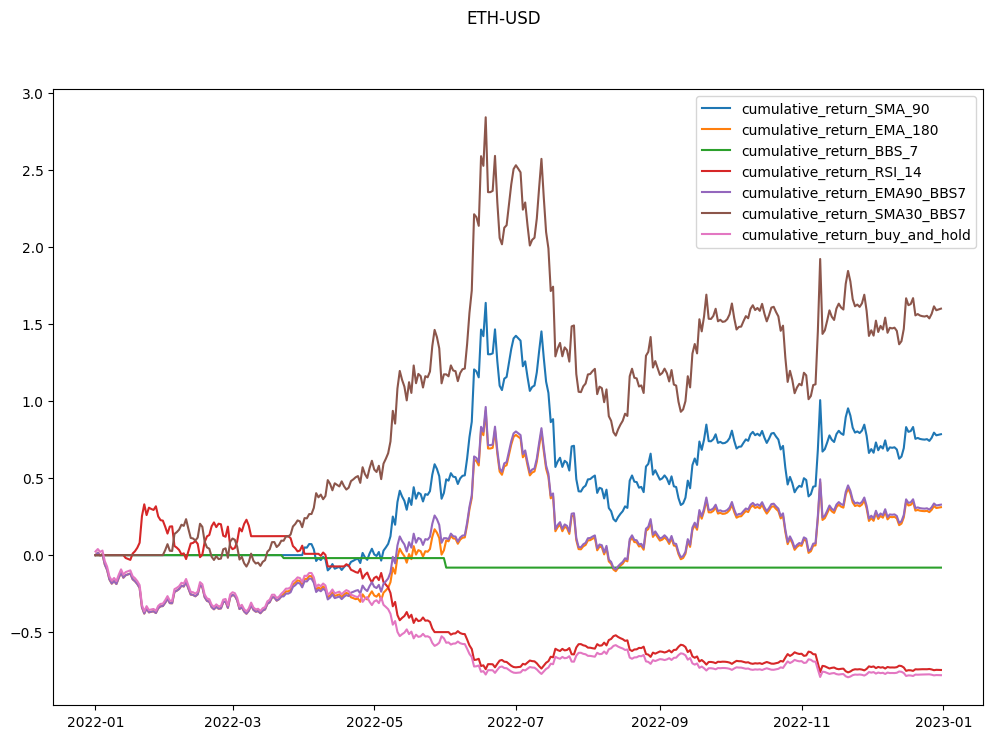

In [64]:
BEST_STRATEGIES = ['SMA_90', 'EMA_180', 'BBS_7', 'RSI_14', 'EMA90_BBS7', 'SMA30_BBS7', 'buy_and_hold']

nrows=1
ncols=1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey='row', sharex=True)
for strategy in BEST_STRATEGIES:
    ax.plot(df_performance_metrics[f'{METRIC}_{strategy}'], label=f"{METRIC}_{strategy}")
# ax.plot(regression_baseline-1, label=f"{metric}_buy_and_hold")
plt.legend()
plt.suptitle(ROBUSTNESS_SET)
plt.show()

**Compare Sharpe Ratio**

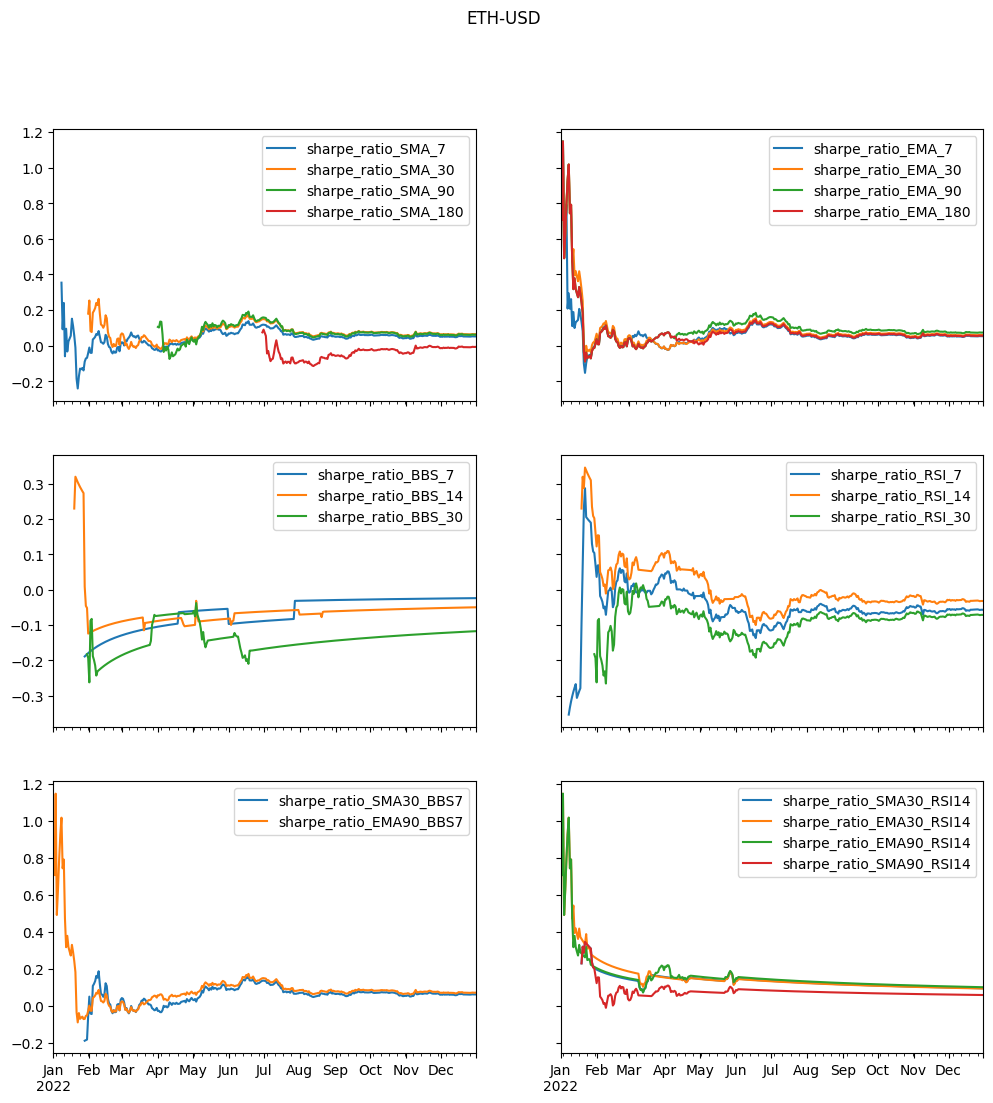

In [119]:
METRIC = 'sharpe_ratio'
STRATEGY_CATEGORIES = ['SMA', 'EMA', 'BBS', 'RSI', 'MA_BBS', 'MA_RSI']

nrows=3
ncols=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), sharey='row', sharex=True)
for i, strategy in enumerate(STRATEGY_CATEGORIES):
    ax = axs[i//ncols][i%ncols]
    if strategy not in ['MA_BBS', 'MA_RSI']:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and col.split("_")[-2]==strategy]]
    else:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and strategy.split("_")[-1] in col and 'MA' in col]]
    df_plot.plot(ax=ax)
plt.suptitle(ROBUSTNESS_SET)
plt.show()

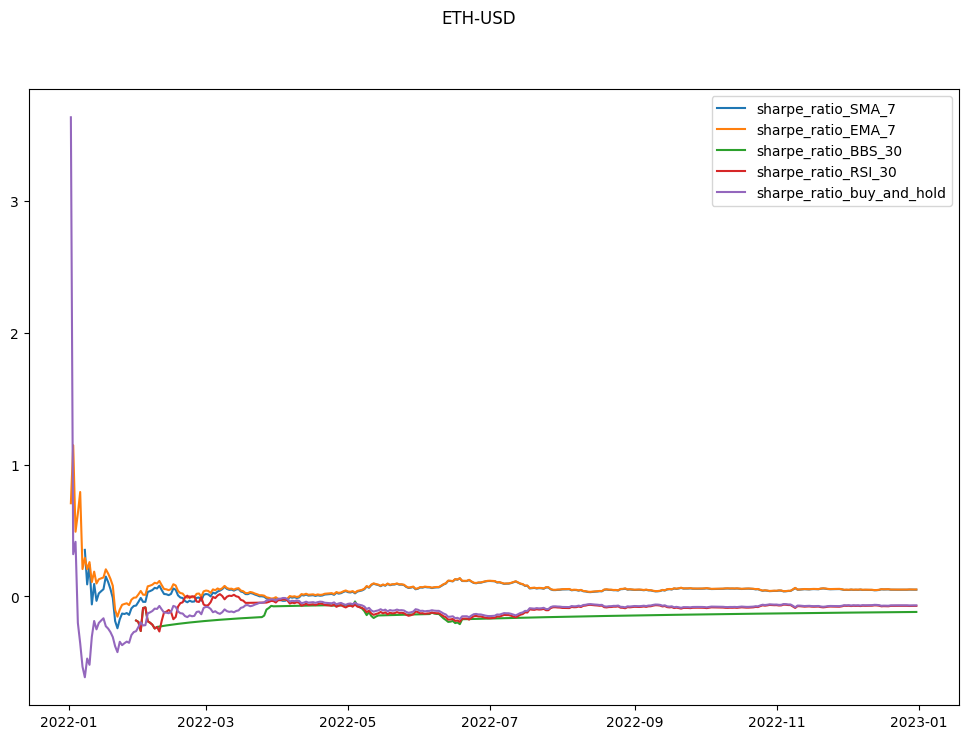

In [120]:
BEST_STRATEGIES = ['SMA_7', 'EMA_7', 'BBS_30', 'RSI_30', 'buy_and_hold']

nrows=1
ncols=1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey='row', sharex=True)
for strategy in BEST_STRATEGIES:
    plt.plot(df_performance_metrics[f'{METRIC}_{strategy}'], label=f"{METRIC}_{strategy}")
plt.legend()
plt.suptitle(ROBUSTNESS_SET)
plt.show()